In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
import tqdm
# set retina display using magic 
%config InlineBackend.figure_format = 'retina'

Typical divergence $\mathcal{O}(10^{-6}\ —\ 10^{-5}\, \textrm{s}^{-1})$

Assume we consider a 2D ($x-z$) grid cell, for which $\frac{\partial u}{\partial x} = (U_1 - U_0)/\Delta x = -10^{-5}$ (divergence). If we require a rigid lid, the vertical velocity at the surface is $W_0 = 0$. Through the continuity equation $\frac{\partial u}{\partial x} + \frac{\partial w}{\partial z} = 0$, we can compute $W_1$ at the bottom of the cell as $\frac{\partial w}{\partial z} = (W_1 - W_0)/\Delta z$ by rearranging terms and finding:
$$ W_1 = (U_0 - U_1)\frac{\Delta z}{\Delta x}.$$

Zonally, within the grid cell, the velocity can be interpolated as follows:
$$ u(x) = U_0 + \frac{x - x_0}{\Delta x}(U_1 - U_0),$$
where $x_0$ is the position of the left cell wall. 
In the vertical (with the z-direction facing downwards), we have a similar situation:
$$ w(z) = W_0 + \frac{z - z_0}{\Delta z}(W_1 - W_0),$$
which reduces to $w(z) = \frac{W_1 \ z}{\Delta z}$ as $W_0 = 0$ at $z_0=0$. 

We can solve $u(x) = \frac{d x}{dt}$ for $x$ as a function of $t$. This yields:
$$x(t)= \frac{\Delta x U_0-e^{\frac{t
   (U_1-U_0)}{\Delta x}} (U_0 (\Delta x-x_0)+U_1 x_0)}{U_0-U_1}.$$

Solving for t gives:
$$
t\to \frac{\Delta x \left(\log
   \left(\frac{U_0 x_0-U_1 x_0-U_0 \text{$\Delta
   $x}}{U_0 x-U_1 x-U_0 \text{$\Delta
   $x}}\right)\right)}{U_0-U_1}
   $$

Setting $U_1 = - U_0$:
$$
t=\frac{\Delta x \left(\log \left(-\frac{\Delta x-2
   x_0}{2 x-\Delta x}\right)\right)}{2 U_0}
   $$

First define the surface velocity function.

In [2]:
def u(t, x, U0=0.1, x0=0, dx=1e4, U1=None, sign=1):
    if U1 is None:
        U1 = - U0
    return sign * (U0 + (x - x0) / dx * (U1 - U0))

And the vertical velocity function.

In [3]:
def w(t, z, U0=0.05, x0=0, dx=1e4, dz=1, U1=None, sign=1):
    if U1 is None:
        U1 = - U0
    return sign * (z / dz) * (U0 - U1) * (dz / dx)

In [4]:
def plot_streamlines(U0=0.05, U1=None, cbar=True):
    X = np.linspace(0, 1e4, 1001)
    Z = np.linspace(0, 1, 1001)
    XX, ZZ = np.meshgrid(X, Z)
    U = u(0, XX, U0=U0, U1=U1, dx=1e4)
    W = w(0, ZZ, U0=U0, U1=U1, dz=1, dx=1e4)
    speed = np.sqrt(U**2 + W**2)

    fig, ax = plt.subplots(figsize=(6,3))
    stream = ax.streamplot(XX, ZZ, U, W, density=2, color=speed, linewidth=1, arrowsize=1, arrowstyle='->')
    # ax.set_xlabel('x [m]')
    # ax.set_ylabel('z [m]')
    ax.set_ylim(1, 0)

    ax.set_xticklabels([f'{int(x)} km' for x in ax.get_xticks() / 1e3])
    ax.set_yticklabels([f'{round(y,2)} m' for y in ax.get_yticks()])

    ax.annotate("", xy=(0, 1.05), xycoords='axes fraction', xytext=(1, 1.05), 
                arrowprops=dict(arrowstyle="<->", color='black'))
    ax.annotate('$\Delta x$', xy=(0.5, 1.075), xycoords='axes fraction', ha='center')

    ax.annotate("", xy=(1.05, 0), xycoords='axes fraction', xytext=(1.05, 1),
                arrowprops=dict(arrowstyle="<->", color='black'))
    ax.annotate('$\Delta z$', xy=(1.075, 0.5), xycoords='axes fraction', va='center')
    if cbar:
        fig.colorbar(stream.lines, ax=ax, label='speed [m/s]', pad=0.125)
    return fig, ax

/tmp/ipykernel_140624/3970606820.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} km' for x in ax.get_xticks() / 1e3])
/tmp/ipykernel_140624/3970606820.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{round(y,2)} m' for y in ax.get_yticks()])


(<Figure size 600x300 with 2 Axes>, <Axes: >)

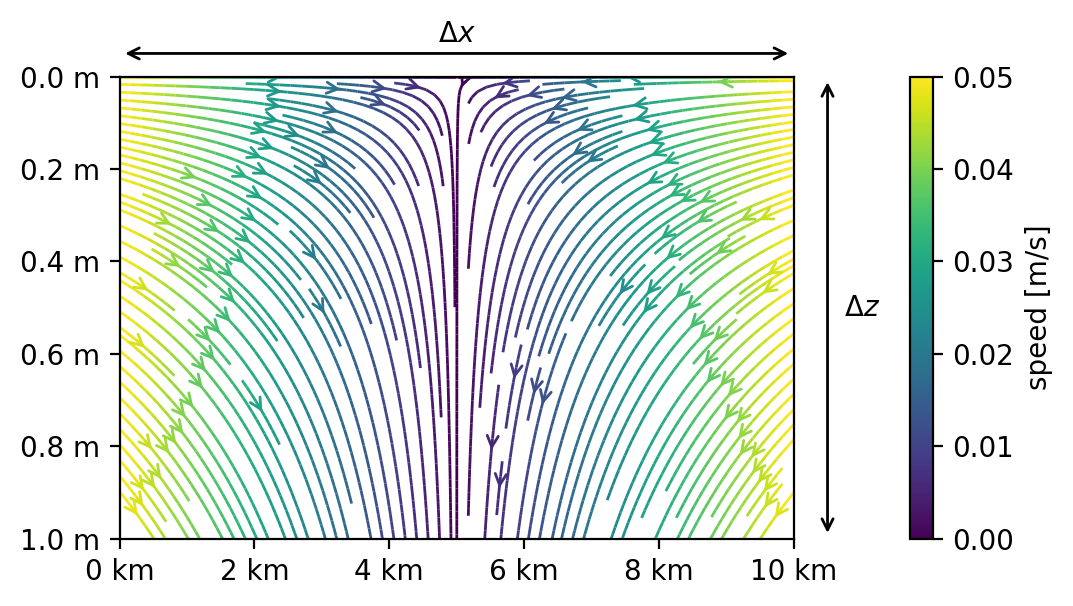

In [5]:
plot_streamlines(U0=0.05, U1=None)

In [6]:
def x_t_horiz(t, x0, X0=0, U0=0.05, U1=None, dx = 1e4):
    if U1 is None:
        U1 = - U0

    return X0 + (U0 * dx - np.exp((t * (U1 - U0)) / dx) * ((U1 - U0) * (x0 - X0) + U0 * dx)) / (U0 - U1)

In [7]:
x0 = np.linspace(0, 1e4, 50)
t = np.arange(0, 7 * 86400, 60*60)
x0_mesh, t_mesh = np.meshgrid(x0, t)

In [8]:
x_sol_analytical = x_t_horiz(t_mesh, x0_mesh)

/tmp/ipykernel_140624/2746305292.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels([f'{int(x)} km' for x in ax[0].get_xticks() / 1e3])
/tmp/ipykernel_140624/2746305292.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_yticklabels([f'{round(y,2)} m' for y in ax[0].get_yticks()])
/tmp/ipykernel_140624/2746305292.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_yticklabels([f'{int(tick)} km' for tick in ax[1].get_yticks()])


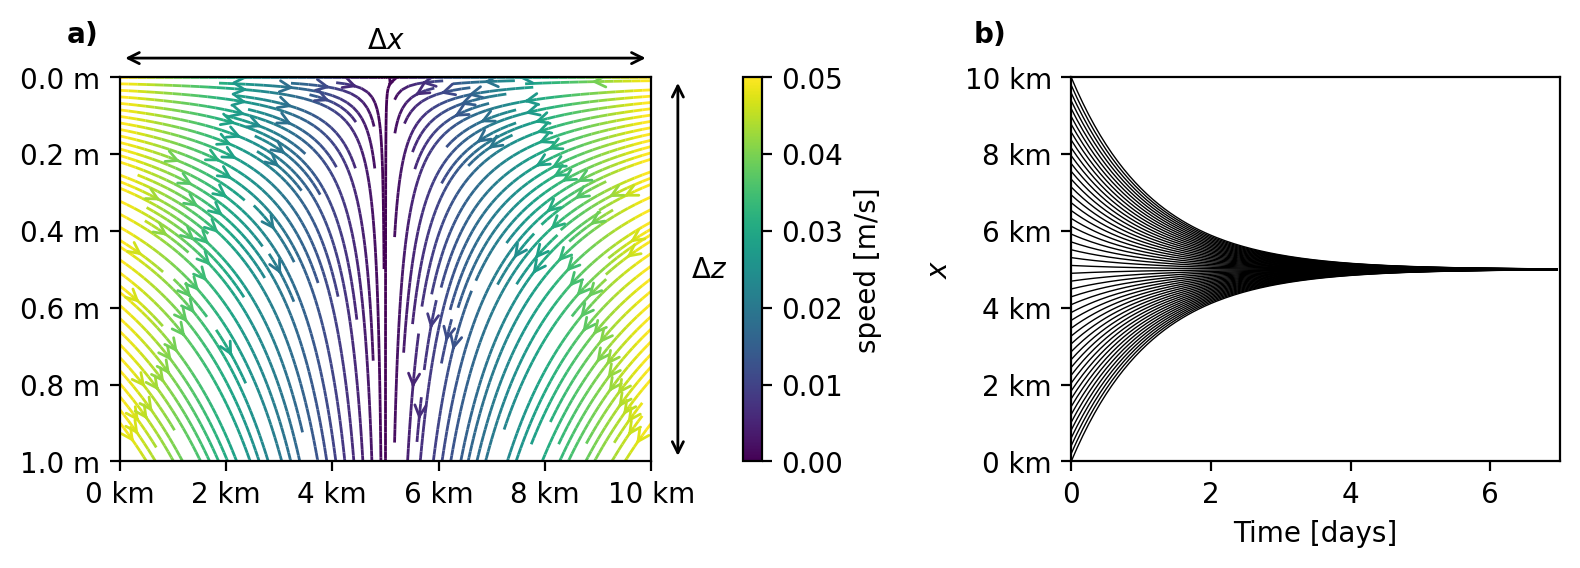

In [10]:
X = np.linspace(0, 1e4, 1001)
Z = np.linspace(0, 1, 1001)
XX, ZZ = np.meshgrid(X, Z)
U = u(0, XX, U0=0.05, U1=None, dx=1e4)
W = w(0, ZZ, U0=0.05, U1=None, dz=1, dx=1e4)
speed = np.sqrt(U**2 + W**2)

fig, ax = plt.subplots(ncols=2, figsize=(8,3), width_ratios=[3, 2])
stream = ax[0].streamplot(XX, ZZ, U, W, density=2, color=speed, linewidth=1, arrowsize=1, arrowstyle='->')
# ax.set_xlabel('x [m]')
# ax.set_ylabel('z [m]')
ax[0].set_ylim(1, 0)

ax[0].set_xticklabels([f'{int(x)} km' for x in ax[0].get_xticks() / 1e3])
ax[0].set_yticklabels([f'{round(y,2)} m' for y in ax[0].get_yticks()])

ax[0].annotate("", xy=(0, 1.05), xycoords='axes fraction', xytext=(1, 1.05), 
            arrowprops=dict(arrowstyle="<->", color='black'))
ax[0].annotate('$\Delta x$', xy=(0.5, 1.075), xycoords='axes fraction', ha='center')

ax[0].annotate("", xy=(1.05, 0), xycoords='axes fraction', xytext=(1.05, 1),
            arrowprops=dict(arrowstyle="<->", color='black'))
ax[0].annotate('$\Delta z$', xy=(1.075, 0.5), xycoords='axes fraction', va='center')

ax[0].text(-0.1, 1.15, r'$\bf{a)}$', transform=ax[0].transAxes, ha='left', va='top')

fig.colorbar(stream.lines, ax=ax[0], label='speed [m/s]', pad=0.125)

ax[1].plot(t / 86400, x_sol_analytical/1000, color='black', lw=0.5);
ax[1].set_ylim(0, 10)
ax[1].set_yticklabels([f'{int(tick)} km' for tick in ax[1].get_yticks()])
ax[1].set_xlabel('Time [days]')
ax[1].set_xlim(0, 7)
ax[1].set_ylabel('$x$')
ax[1].text(-0.2, 1.15, r'$\bf{b)}$', transform=ax[1].transAxes, ha='left', va='top')
plt.tight_layout()
plt.savefig('streamlines.pdf', bbox_inches='tight')
# print(ax[1].get_yticks())


/tmp/ipykernel_140624/3970606820.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} km' for x in ax.get_xticks() / 1e3])
/tmp/ipykernel_140624/3970606820.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{round(y,2)} m' for y in ax.get_yticks()])


(<Figure size 600x300 with 2 Axes>, <Axes: >)

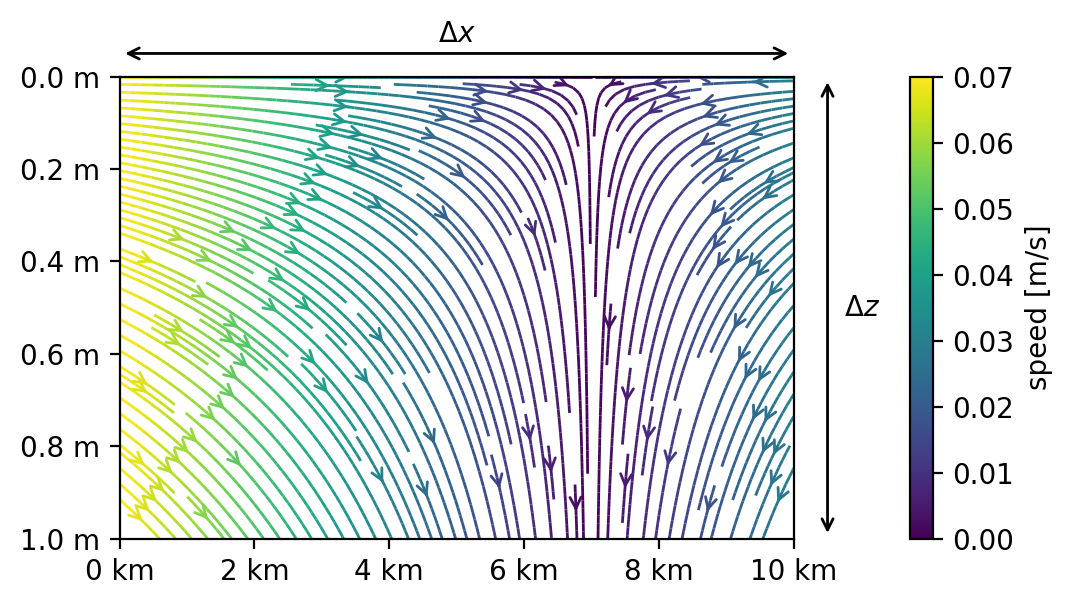

In [11]:
plot_streamlines(U0=0.07, U1=-0.03)

In [12]:
def t_to_point(x, dx = 1e4, x0=0, U0=0.05):
    return dx * np.log(-(dx-2*x0)/(2*x-dx)) / (2 * U0)

Plotting $t(x)$ given $x_0 = 0$ and $x_0 = \Delta x$

/tmp/ipykernel_140624/3427233928.py:2: RuntimeWarning: invalid value encountered in log
  return dx * np.log(-(dx-2*x0)/(2*x-dx)) / (2 * U0)
/tmp/ipykernel_140624/3427233928.py:2: RuntimeWarning: invalid value encountered in log
  return dx * np.log(-(dx-2*x0)/(2*x-dx)) / (2 * U0)
/tmp/ipykernel_140624/2084806933.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks() / x_conv)


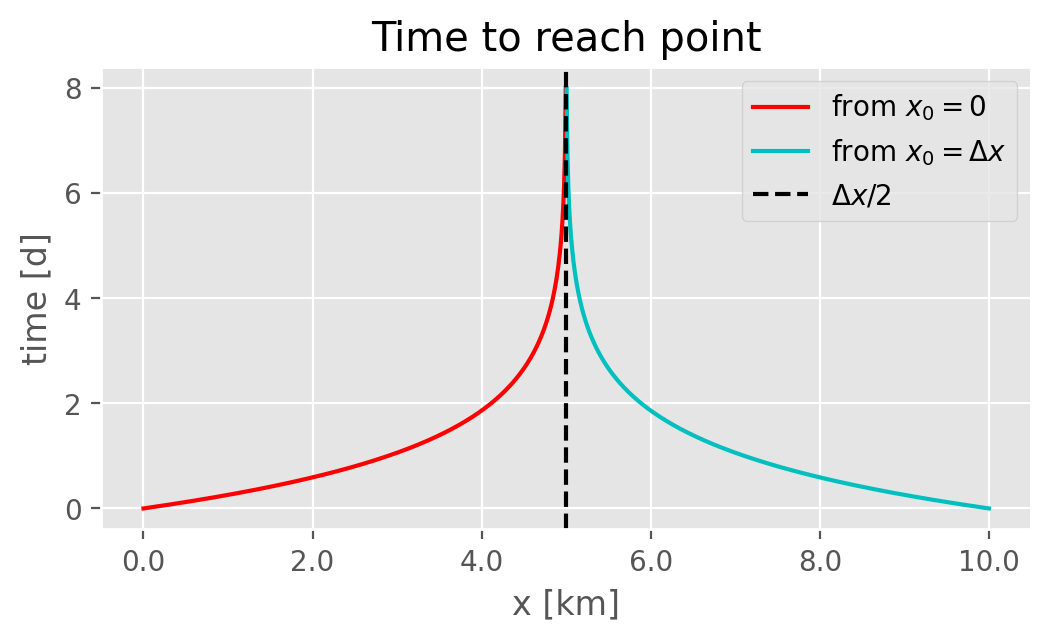

In [13]:
dx = 1e4
x0 = 0
U0 = 0.05
x = np.linspace(0, dx, 1000)
t = t_to_point(x, dx, x0, U0)
t_conv = 60*60*24
x_conv = 1e3

with plt.style.context('ggplot'):
    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(x, t_to_point(x, dx, x0, U0) / t_conv, 'r', label="from $x_0=0$")
    ax.plot(x, t_to_point(x, dx, x0=dx, U0=U0) / t_conv, 'c', label="from $x_0=\Delta x$")
    ax.set_xlabel('x [km]')
    ax.set_ylabel('time [d]')
    if x_conv != 1:
        ax.set_xticklabels(ax.get_xticks() / x_conv)
        ax.set_xlabel('x [km]')
    # plot vertical line at x=dx/2
    ax.axvline(dx/2, color='k', linestyle='--', label='$\Delta x/2$')
    ax.legend()
    ax.set_title('Time to reach point')

### Two cells

In [14]:
def plot_streamlines_2cell(U0=0.05, U1=None, U2=None, cbar=True):
    X = np.linspace(0, 1e4, 1001)
    Z = np.linspace(0, 1, 1001)
    XX, ZZ = np.meshgrid(X, Z)
    U_left = u(0, XX, U0=U0, U1=U1, dx=1e4)
    W_left = w(0, ZZ, U0=U0, U1=U1, dz=1, dx=1e4)
    U_right = u(0, XX, U0=U1, U1=U2, dx=1e4)
    W_right = w(0, ZZ, U0=U1, U1=U2, dz=1, dx=1e4)
    speed_left = np.sqrt(U_left**2 + W_left**2)
    speed_right = np.sqrt(U_right**2 + W_right**2)


    fig, ax = plt.subplots(figsize=(6,3))
    stream_left = ax.streamplot(XX, ZZ, U_left, W_left, density=2, color=speed_left, linewidth=1, arrowsize=1, arrowstyle='->')
    stream_right = ax.streamplot(XX + 10_000, ZZ, U_right, W_right, density=2, color=speed_right, linewidth=1, arrowsize=1, arrowstyle='->')

    ax.axvline(10_000, linewidth=1, color='black')
    # ax.set_xlabel('x [m]')
    # ax.set_ylabel('z [m]')
    ax.set_ylim(1, 0)

    ax.set_xticklabels([f'{int(x)} km' for x in ax.get_xticks() / 1e3])
    ax.set_yticklabels([f'{round(y,2)} m' for y in ax.get_yticks()])

    ax.annotate("", xy=(0, 1.05), xycoords='axes fraction', xytext=(0.5, 1.05), 
                arrowprops=dict(arrowstyle="<->", color='black'))
    ax.annotate('$\Delta x$', xy=(0.25, 1.075), xycoords='axes fraction', ha='center')
    ax.annotate("", xy=(0.5, 1.05), xycoords='axes fraction', xytext=(1, 1.05), 
                arrowprops=dict(arrowstyle="<->", color='black'))
    ax.annotate('$\Delta x$', xy=(0.75, 1.075), xycoords='axes fraction', ha='center')
 
    ax.annotate("", xy=(1.05, 0), xycoords='axes fraction', xytext=(1.05, 1),
                arrowprops=dict(arrowstyle="<->", color='black'))
    ax.annotate('$\Delta z$', xy=(1.075, 0.5), xycoords='axes fraction', va='center')
    # if cbar:
    #     fig.colorbar(stream.lines, ax=ax, label='speed [m/s]', pad=0.125)
    return fig, ax

/tmp/ipykernel_140624/1588405862.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} km' for x in ax.get_xticks() / 1e3])
/tmp/ipykernel_140624/1588405862.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{round(y,2)} m' for y in ax.get_yticks()])


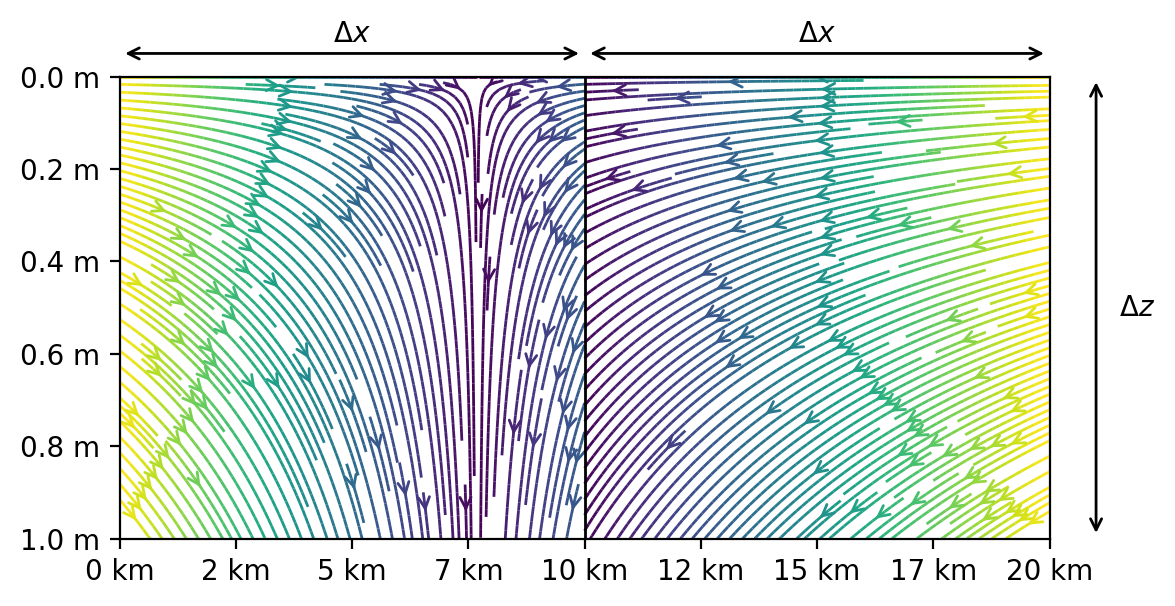

In [15]:
fig, ax = plot_streamlines_2cell(0.05, -0.015, -0.04)
fig.savefig('streamlines_2cell.pdf', bbox_inches='tight')

# Numerical integration

Define an RK4 Solver.

In [16]:
def rk4(f, x, t, dt, **kwargs):
    k1 = f(t, x, **kwargs)
    k2 = f(t + dt/2, x + k1 * dt/2, **kwargs)
    k3 = f(t + dt/2, x + k2 * dt/2, **kwargs)
    k4 = f(t + dt, x + k3 * dt, **kwargs)
    return x + dt / 6 * (k1 + 2*k2 + 2*k3 + k4)

In [17]:
def rk2(f, x, t, dt, **kwargs):
    k1 = f(t, x, **kwargs)
    k2 = f(t + dt, x + k1 * dt, **kwargs)
    return x + dt / 2 * (k1 + k2)

And Euler Forward

In [18]:
def EulerForward(f, x, t, dt, **kwargs):
    return x + dt * f(t, x, **kwargs)

Wrap things up in a loop

In [19]:
def integration_loop(f, x0, t0, t_end, dt, save_step=1, int_function=rk4, **kwargs):
    # Adjust total_steps to ensure it's a multiple of save_step
    total_steps = int(np.ceil((np.abs(t_end - t0)) / np.abs(dt)))
    if total_steps % save_step != 0:
        total_steps += save_step - (total_steps % save_step)
    
    # Calculate the number of times output will be saved, including the initial state
    num_saves = total_steps // save_step + 1  # +1 to include the initial state

    # Time points to save the output, ensuring the endpoint is included
    t_out = np.linspace(t0, t_end, num_saves)  # Adjusted to ensure the endpoint is included
    
    if type(x0) is not np.ndarray and type(x0) is not list:
        x0 = np.array([x0])
    x_out = np.zeros((len(t_out), len(x0)))
    x_out[0, :] = x0  # Initial state already correctly set

    x_temp = x0
    save_idx = 1  # Start saving from the next index since initial state is already saved
    for step in tqdm.tqdm(range(1, total_steps + 1)):
        x_temp = int_function(f, x_temp, t0 + (step-1)*dt, dt, **kwargs)
        if step % save_step == 0:
            x_out[save_idx, :] = x_temp  # Use save_idx directly without -1
            save_idx += 1

    class rk4_out:
        def __init__(self, t, x):
            self.t = t
            self.x = x

    return rk4_out(t_out, x_out)

## RK4 & Euler-Forward

In [20]:
sol_rk4_forward = integration_loop(u, 0, 0, 10 * 24 * 60 * 60, save_step=10, dt=60, U0=0.05, dx=1e4)
sol_rk4_backward = integration_loop(u, sol_rk4_forward.x[-1], 10 * 24 * 60 * 60, 0, save_step=10, dt=-60, U0=0.05, dx=1e4, sign=1)


100%|██████████| 14400/14400 [00:00<00:00, 29430.01it/s]


In [21]:
def sensitivity_plot(solver, dt, U0, u_func=u, 
                     return_results=False, 
                     t0=0, t_end=10 * 24 * 60 * 60, 
                     save_step=10, ylim="middle", x0=0,
                     dx = 1e4,
                     **kwargs):
    if solver == 'rk4':
        solverfunc = rk4
    elif solver == 'EulerForward':
        solverfunc = EulerForward
    elif solver == 'rk2':
        solverfunc = rk2
    else:
        raise ValueError("solver must be 'rk4' or 'EulerForward'")
    sol_forward_sensitivity = integration_loop(u_func, x0, t0=t0, t_end=t_end, save_step=save_step, dt=dt, U0=U0, dx=dx, int_function=solverfunc, **kwargs)
    sol_backward_sensitivity = integration_loop(u_func, sol_forward_sensitivity.x[-1], t0=t_end, t_end=t0, save_step=save_step, dt=-dt, U0=U0, dx=dx, sign=1, int_function=solverfunc, **kwargs)

    fig, ax = plt.subplots(figsize=(6,3))
    ax.plot(sol_forward_sensitivity.t, sol_forward_sensitivity.x, label='Forward')
    ax.plot(sol_backward_sensitivity.t, sol_backward_sensitivity.x, label='Backward', linestyle='--')

    days = t_end / (24 * 60 * 60)
    ax.set_xlabel('t')
    ax.set_ylabel('x(t)')
    ax.set_title(f'Solution of dx/dt using {solver}, dt={dt}s, U0={U0} m/s')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0, t_end)
    ax.set_xticks(np.arange(0, t_end + 1, 24*60*60))  # set ticks every 86400 seconds (one day)
    ax.set_xticklabels([f'{int(day)} d' for day in np.arange(0, days + 1)])
    if type(ylim) is str:
        if ylim == "full":
            ax.set_ylim(0, 1e4)
        elif ylim == "middle":
            ax.set_ylim(0, 6e3)
    elif ylim is not None:
        ax.set_ylim(ylim)
    # ax.set_ylim(0, 1e4)
    plt.show()

    if return_results:
        return sol_forward_sensitivity, sol_backward_sensitivity

100%|██████████| 14400/14400 [00:00<00:00, 28753.03it/s]


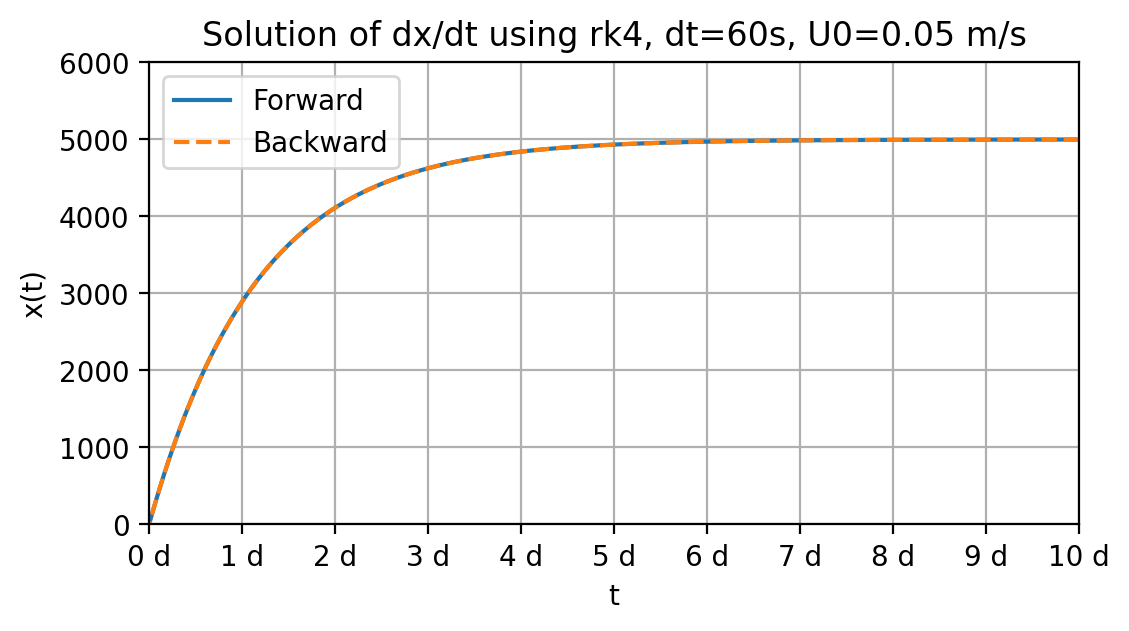

In [22]:
sol_rk4_forward, sol_rk4_backward = sensitivity_plot('rk4', 60, 0.05, return_results=True)

100%|██████████| 1440/1440 [00:00<00:00, 27319.76it/s]

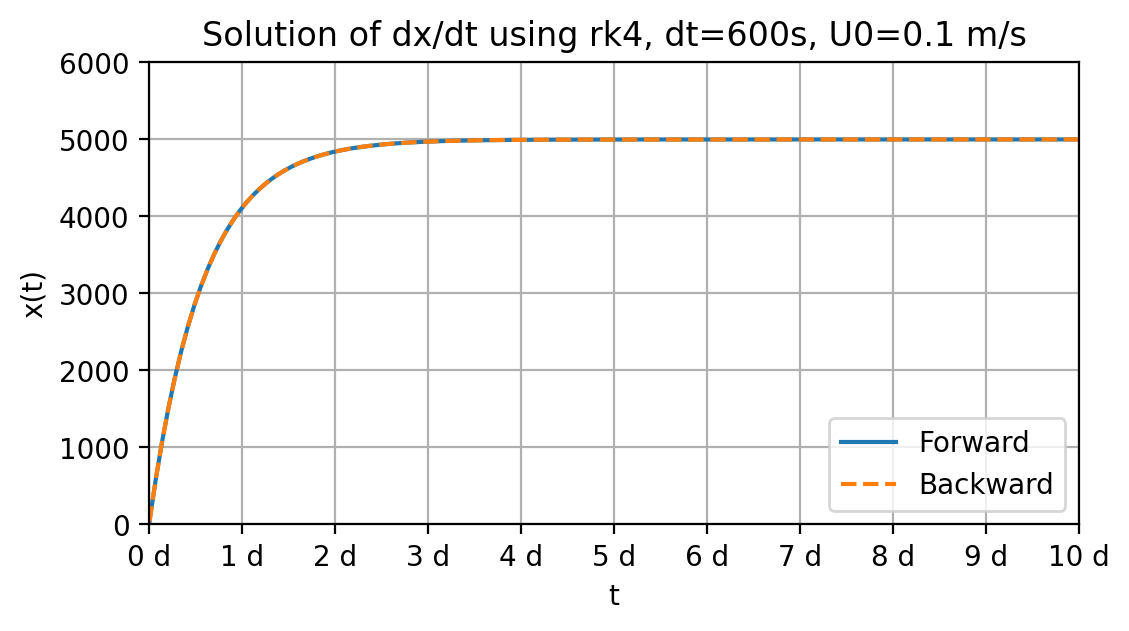

In [23]:
sensitivity_plot('rk4', 600, 0.1)

100%|██████████| 14400/14400 [00:00<00:00, 125030.23it/s]

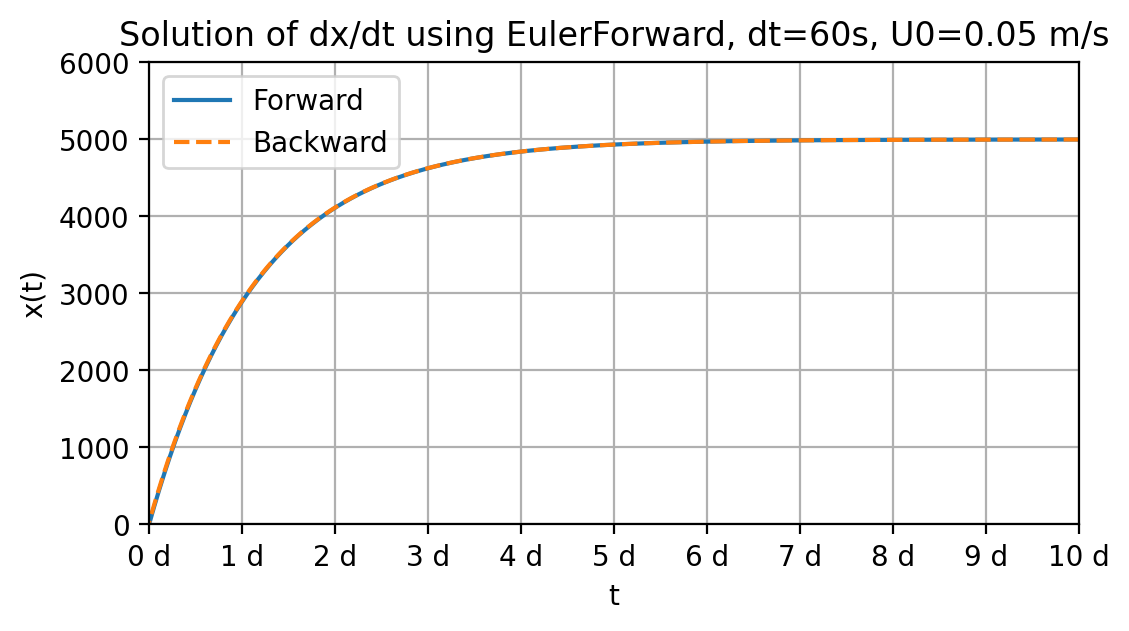

In [24]:
sol_EF_forward, sol_EF_backward = sensitivity_plot('EulerForward', 60, 0.05, return_results=True)

100%|██████████| 1440/1440 [00:00<00:00, 114932.12it/s]


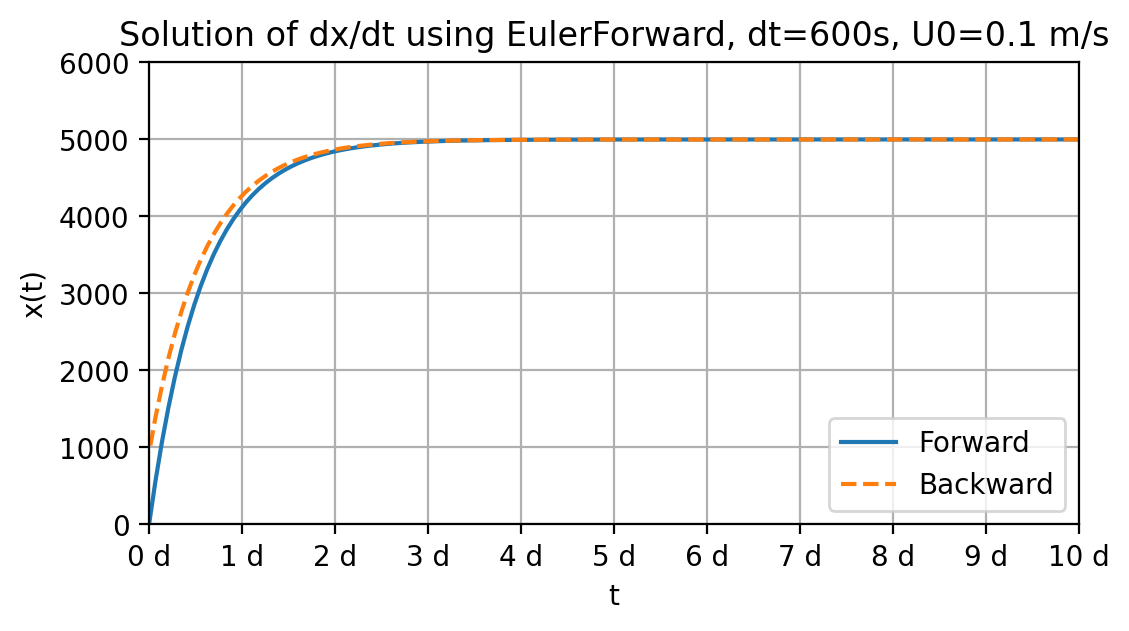

In [25]:
sensitivity_plot('EulerForward', 600, 0.1)

100%|██████████| 240/240 [00:00<00:00, 54403.77it/s]


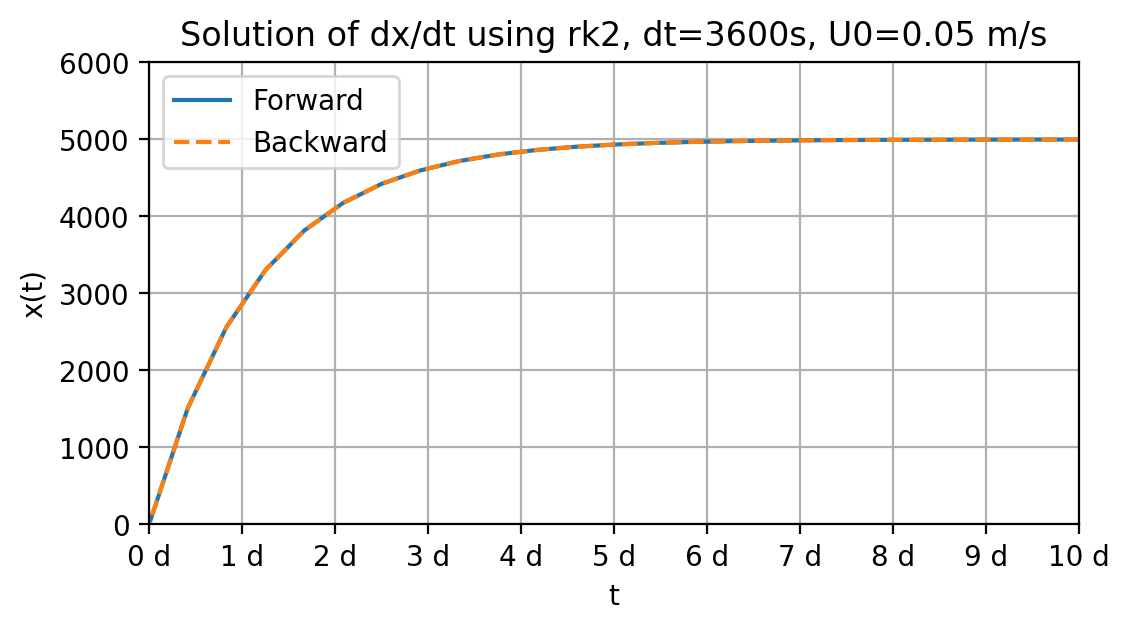

In [26]:
sol_rk2_forward, sol_rk2_backward = sensitivity_plot('rk2', 3600, 0.05, return_results=True)

100%|██████████| 1440/1440 [00:00<00:00, 112053.54it/s]


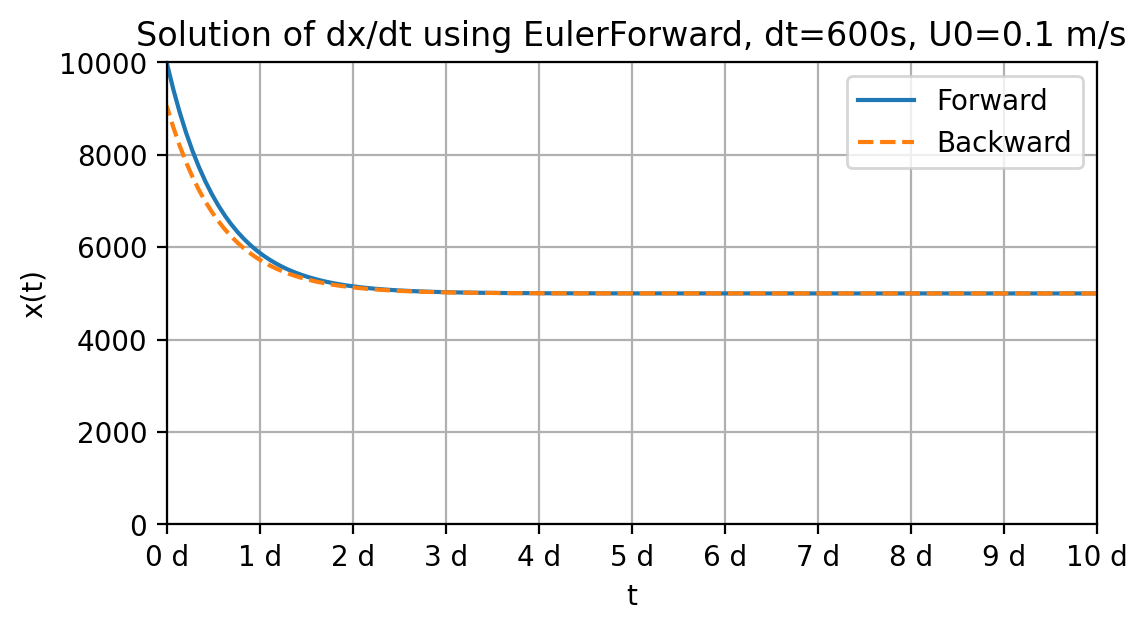

In [27]:
sensitivity_plot('EulerForward', 600, 0.1, x0=1e4, ylim='full')

100%|██████████| 240/240 [00:00<00:00, 26401.41it/s]


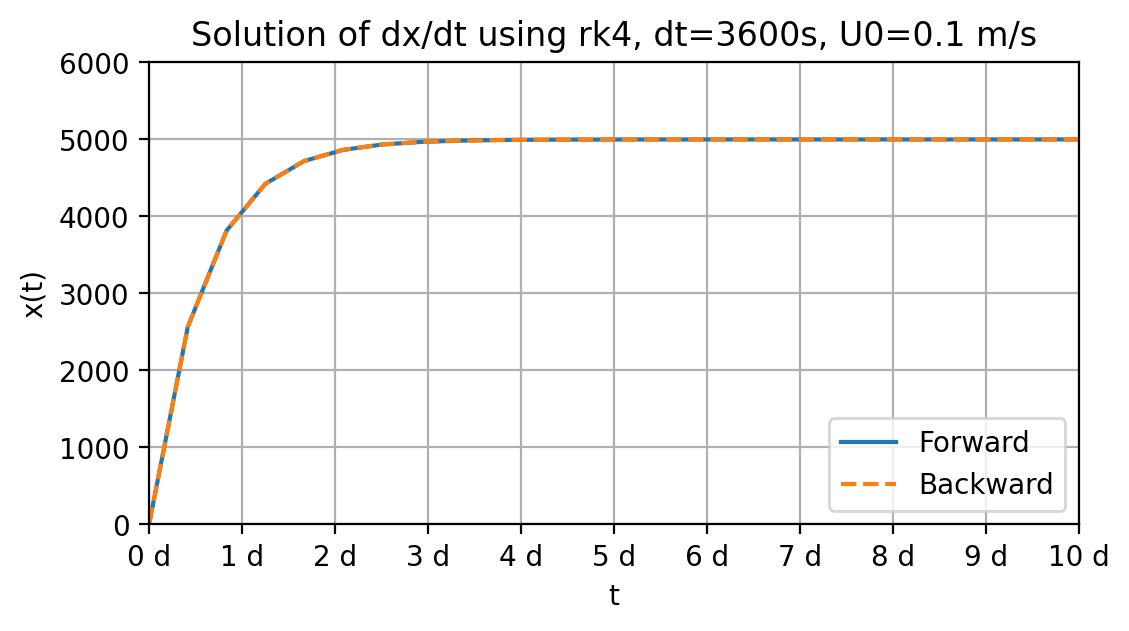

In [28]:
sensitivity_plot('rk4', 60 * 60, 0.1)

100%|██████████| 240/240 [00:00<00:00, 94236.38it/s]


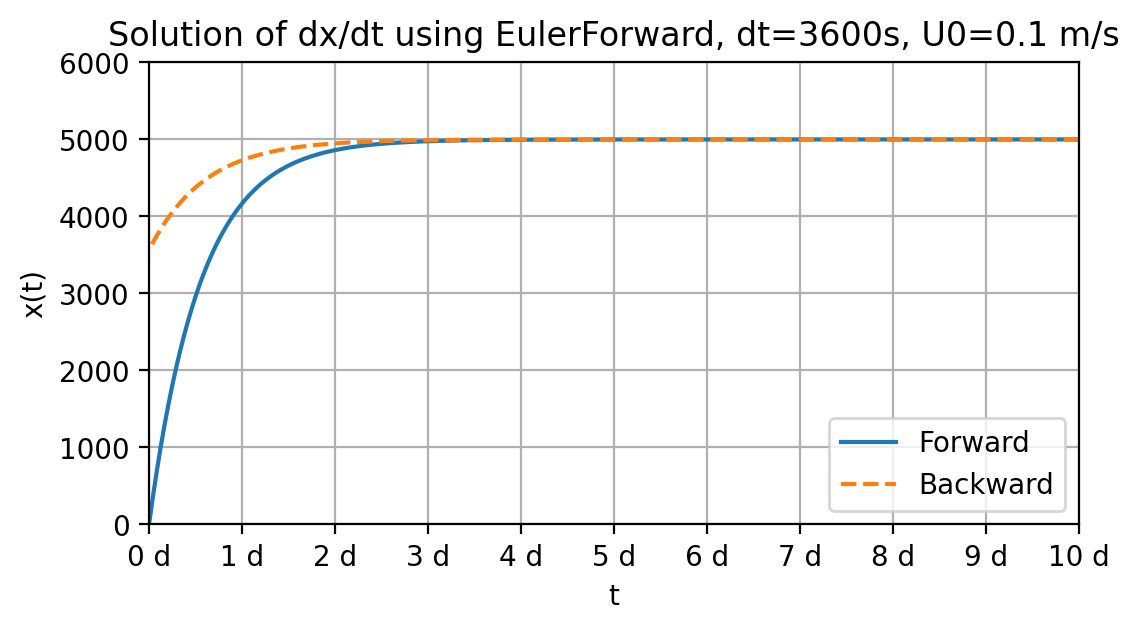

In [29]:
sensitivity_plot('EulerForward', 60 * 60, 0.1, save_step=1)

In [30]:
sol_rk4_forward = integration_loop(u, 0, 0, 10 * 24 * 60 * 60, save_step=10, dt=60, U0=0.05, dx=1e4, int_function=rk4)
sol_rk4_backward = integration_loop(u, sol_rk4_forward.x[-1], 10 * 24 * 60 * 60, 0, save_step=10, dt=-60, U0=0.05, dx=1e4, sign=1, int_function=rk4)
sol_rk4_backward_perturbed = integration_loop(u, np.random.normal(sol_rk4_forward.x[-1], 1e-10, size=1000), 10 * 24 * 60 * 60, 0, save_step=10, dt=-60, U0=0.05, dx=1e4, sign=1, int_function=rk4)

100%|██████████| 14400/14400 [00:00<00:00, 19988.39it/s]


# Adding noise

In [31]:
def u_small_noise(t, x, U0=0.1, x0=0, dx=1e4, U1=None, sign=1, small_noise=1e-15):
    if U1 is None:
        U1 = - U0
    return sign * (U0 + (x - x0) / dx * (U1 - U0)) + small_noise

100%|██████████| 14400/14400 [00:00<00:00, 25789.67it/s]
/tmp/ipykernel_140624/2428464036.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


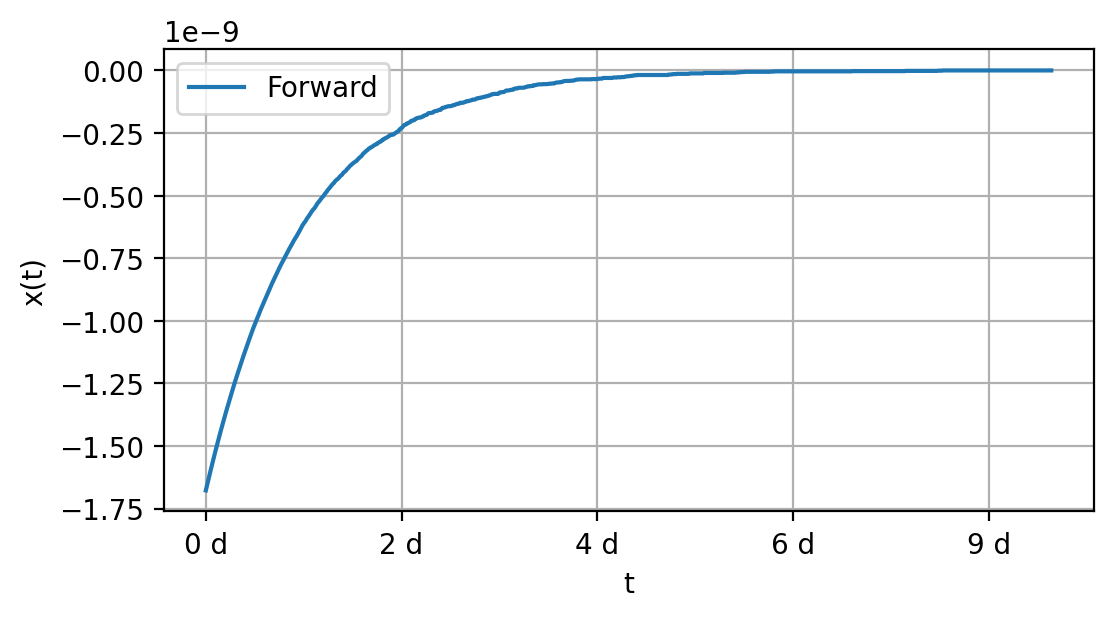

In [32]:
sol_forward_small_noise = integration_loop(u_small_noise, 0, t0=0, t_end=10*24*60*60, save_step=10, dt=60, U0=U0, dx=1e4, int_function=rk4)
sol_backward_small_noise = integration_loop(u_small_noise, sol_forward_small_noise.x[-1], t0=10*24*60*60, t_end=0, save_step=10, dt=-60, U0=U0, dx=1e4, sign=1, int_function=rk4)

fig, ax = plt.subplots(figsize=(6,3))
# ax.plot(sol_forward_small_noise.t, sol_forward_small_noise.x, label='Forward')
# ax.plot(sol_backward_small_noise.t, sol_backward_small_noise.x, label='Backward', linestyle='--')
ax.plot(sol_forward_small_noise.t, sol_forward_small_noise.x-sol_backward_small_noise.x[::-1], label='Forward')
# ax.plot(sol_backward_small_noise.t, sol_backward_small_noise.x, label='Backward', linestyle='--')
ax.set_xlabel('t')
ax.set_ylabel('x(t)')
# ax.set_title(f'Solution of dx/dt using rk4, with noise, dt=}s, U0={U0} m/s')
ax.legend()
ax.grid(True)
# ax.set_xlim(0, 10*24*60*60)
ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])
# if type(ylim) is str:
#     if ylim == "full":
#         ax.set_ylim(0, 1e4)
#     elif ylim == "middle":
#         ax.set_ylim(0, 6e3)
# elif ylim is not None:
#     ax.set_ylim(ylim)
# ax.set_ylim(0, 1e4)
plt.show()


Add a velicty function with a random walk.

In [33]:
def u_random_walk(t, x, U0=0.05, x0=0, dx=1e4, U1=None, sign=1, kh=0.01, dt_random=None):
    if U1 is None:
        U1 = - U0
    if dt_random is None:
        raise ValueError("dt must be specified")
    if type(x) is not np.ndarray and type(x) is not list:
        x = np.array([x])
    dW = np.random.normal(0, np.sqrt(np.abs(dt_random)), size=len(x))
    return sign * (U0 + (x - x0) / dx * (U1 - U0)) + np.sqrt(2*kh) * dW

In [34]:
kh_sensitivity = [1e-6, 1e-4, 1e-2, 1]

In [35]:
dict_rk4_kh_sensitivity = {kh: {} for kh in kh_sensitivity}
for kh in dict_rk4_kh_sensitivity.keys():
    dict_rk4_kh_sensitivity[kh]["forward"] = integration_loop(u_random_walk, np.zeros(1000), 0, 10 * 24 * 60 * 60, save_step=10, dt=60, U0=0.05, dx=1e4, dt_random=60, kh=kh)
    dict_rk4_kh_sensitivity[kh]["backward"] = integration_loop(u_random_walk, np.ones(1000)*sol_rk4_forward.x[-1], 10 * 24 * 60 * 60, 0, save_step=10, dt=-60, U0=0.05, dx=1e4, sign=1, dt_random=-60, kh=kh)


100%|██████████| 14400/14400 [00:02<00:00, 4959.84it/s]


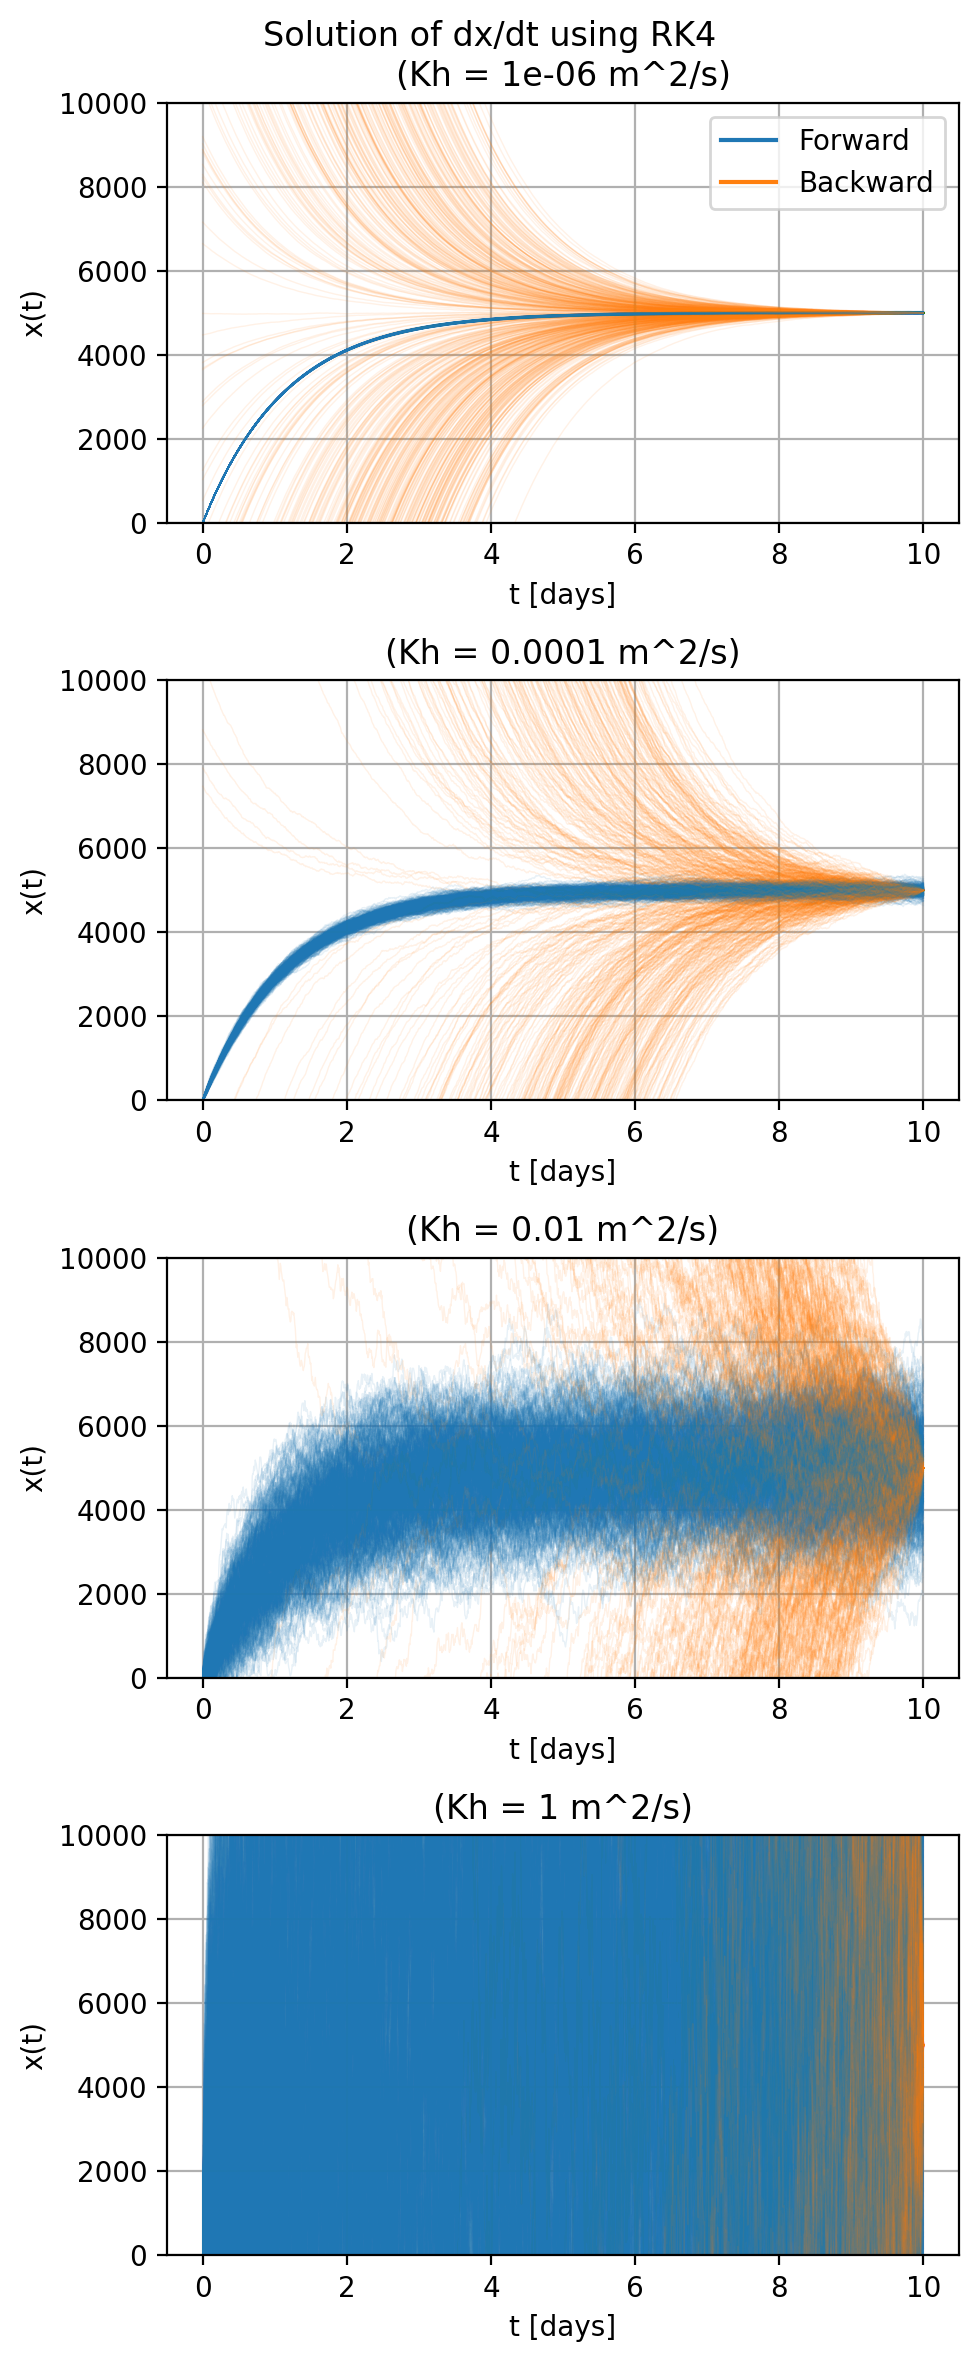

In [36]:
plt.style.context('default')
fig, ax = plt.subplots(nrows=4, figsize=(5,12))
scale_t = 86400
for row, kh in enumerate(dict_rk4_kh_sensitivity.keys()):
    for i in range(500):
        ax[row].plot(dict_rk4_kh_sensitivity[kh]["forward"].t / scale_t, dict_rk4_kh_sensitivity[kh]["forward"].x[:, i], alpha=0.1, linewidth=0.5, color='C0')
        ax[row].plot(dict_rk4_kh_sensitivity[kh]["backward"].t / scale_t, dict_rk4_kh_sensitivity[kh]["backward"].x[:, i], alpha=0.1, linewidth=0.5, color='C1')
    if row == 0:
        labels = ["Forward", "Backward"]  
        dummies = [ax[row].plot([], [], f'C{i}')[0] for i in range(len(labels))]
        ax[row].legend(dummies, labels, loc='upper right')
    ax[row].set_xlabel('t [days]')
    ax[row].set_ylabel('x(t)')
    ax[row].set_ylim(0, 1e4)
    ax[row].grid(True)
    ax[row].set_title(f"(Kh = {kh} m^2/s)")
fig.suptitle('Solution of dx/dt using RK4')
fig.tight_layout()
plt.show()

## RK45

In [37]:
sol_rk45_forward = integrate.solve_ivp(u, (0, 10 * 24 * 60 *60), [0], method='RK45', args=(0.05, 0, 1e4, None, 1), max_step=60)
sol_rk45_backward = integrate.solve_ivp(u, (0, 10 * 24 * 60 *60), [sol_rk45_forward.y[0, -1]], method='RK45', args=(0.05, 0, 1e4, None, -1), max_step=60)

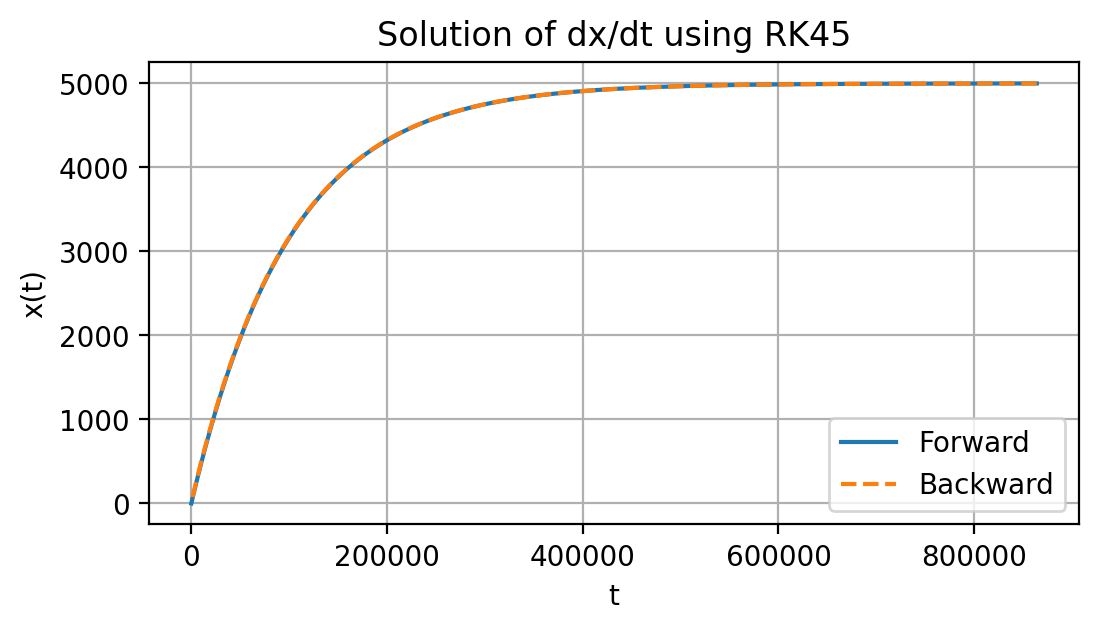

In [38]:
fig, ax = plt.subplots(figsize=(6,3))
ax.plot(sol_rk45_forward.t, sol_rk45_forward.y[0], label='Forward')
ax.plot(sol_rk45_backward.t[::-1], sol_rk45_backward.y[0], label='Backward', linestyle='--')

ax.set_xlabel('t')
ax.set_ylabel('x(t)')
ax.set_title('Solution of dx/dt using RK45')
ax.legend()
ax.grid(True)
plt.show()

## Comparison of all algos

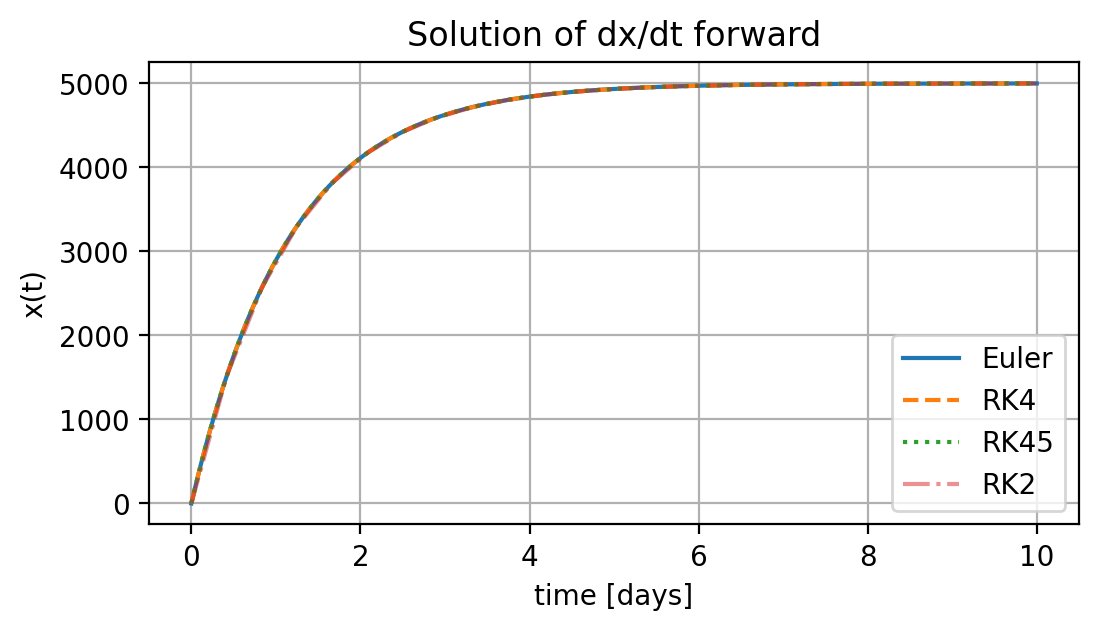

In [39]:
# plot rk4 and rk45 solutions forward
fig, ax = plt.subplots(figsize=(6,3))
rescale_t = 86400
ax.plot(sol_EF_forward.t / rescale_t, sol_EF_forward.x, label='Euler')
ax.plot(sol_rk4_forward.t / rescale_t, sol_rk4_forward.x, label='RK4', linestyle='--')
ax.plot(sol_rk45_forward.t / rescale_t, sol_rk45_forward.y[0], label='RK45', linestyle=':')
ax.plot(sol_rk2_forward.t / rescale_t, sol_rk2_forward.x, label='RK2', linestyle='-.', alpha=0.5)

ax.set_xlabel('time [days]')
ax.set_ylabel('x(t)')
ax.set_title('Solution of dx/dt forward')
ax.legend()
ax.grid(True)
plt.show()

# Moving flow

Specify an oscilating flow, where on a daily cycle, $U_0$ varies between 0.075 and 0.025, and $U_1$ is specified so that $\partial U/\partial x = 10^{-5}\, s^{-1}$

In [40]:
def u_moving(t, x, U0=0.05, x0=0, dx=1e4, U0_amp=0.05, U0_period=24 * 60 * 60, dudx=-1e-5, sign=1):
    U0_inst = U0 + U0_amp * np.sin(2 * np.pi * t / U0_period)
    U1_inst = dudx * dx + U0_inst
    return sign * (U0_inst + (x - x0) / dx * (U1_inst - U0_inst))

In [41]:
def u_moving_sharply(t, x, U0=0.05, x0=0, dx=1e4, U0_amp=0.05, U0_period=24 * 60 * 60, dudx=-1e-5, sign=1):
    U0_inst = U0 + U0_amp * np.sign(np.sin(2 * np.pi * t / U0_period))
    U1_inst = dudx * dx + U0_inst
    return sign * (U0_inst + (x - x0) / dx * (U1_inst - U0_inst))

In [42]:
def u_moving_sharply2(t, x, U0=0.05, x0=0, dx=1e4, U0_amp=0.05, U0_period=24 * 60 * 60, dudx=-1e-5, sign=1):
    U0_inst = U0 - U0_amp * (2 * np.abs(t % (2*U0_period) - U0_period) / U0_period - 1)
    U1_inst = dudx * dx + U0_inst
    return sign * (U0_inst + (x - x0) / dx * (U1_inst - U0_inst))

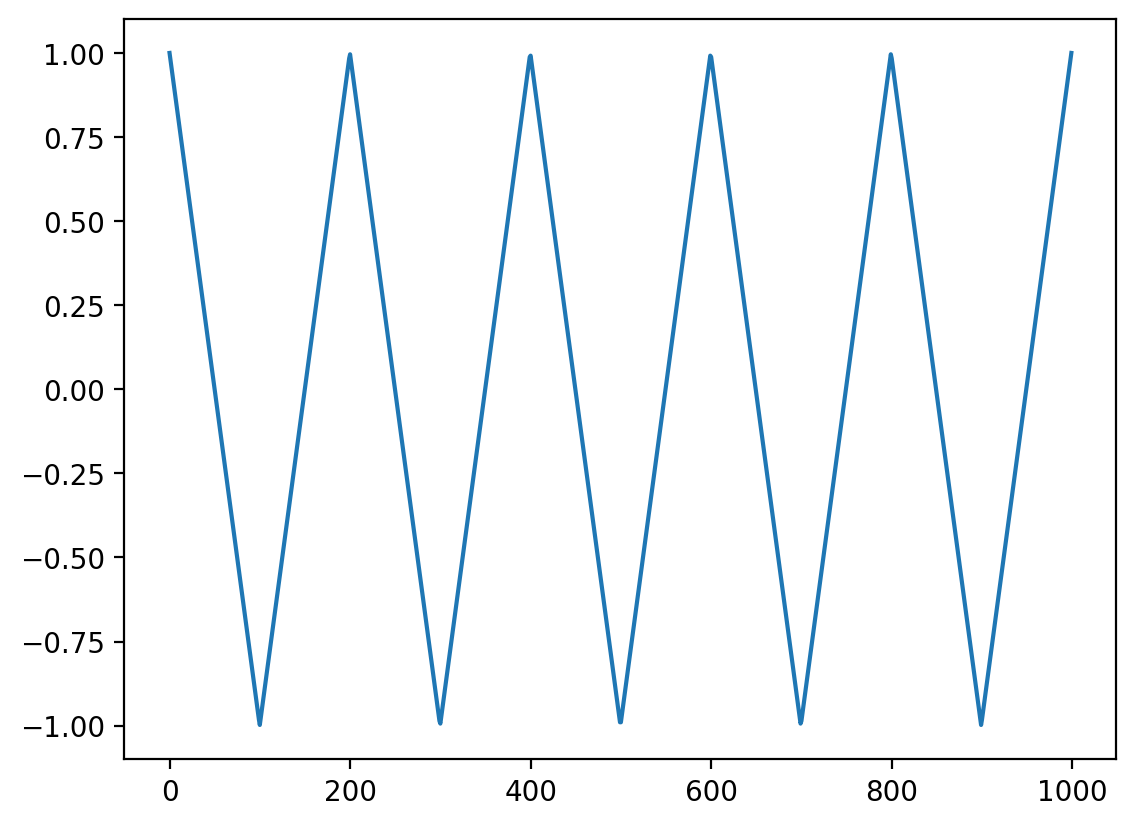

In [43]:
U0_period = 24 * 60 * 60

plt.plot(2 * np.abs(np.linspace(0, 10*U0_period, 1000) % (2* U0_period) - U0_period) / (U0_period) - 1)

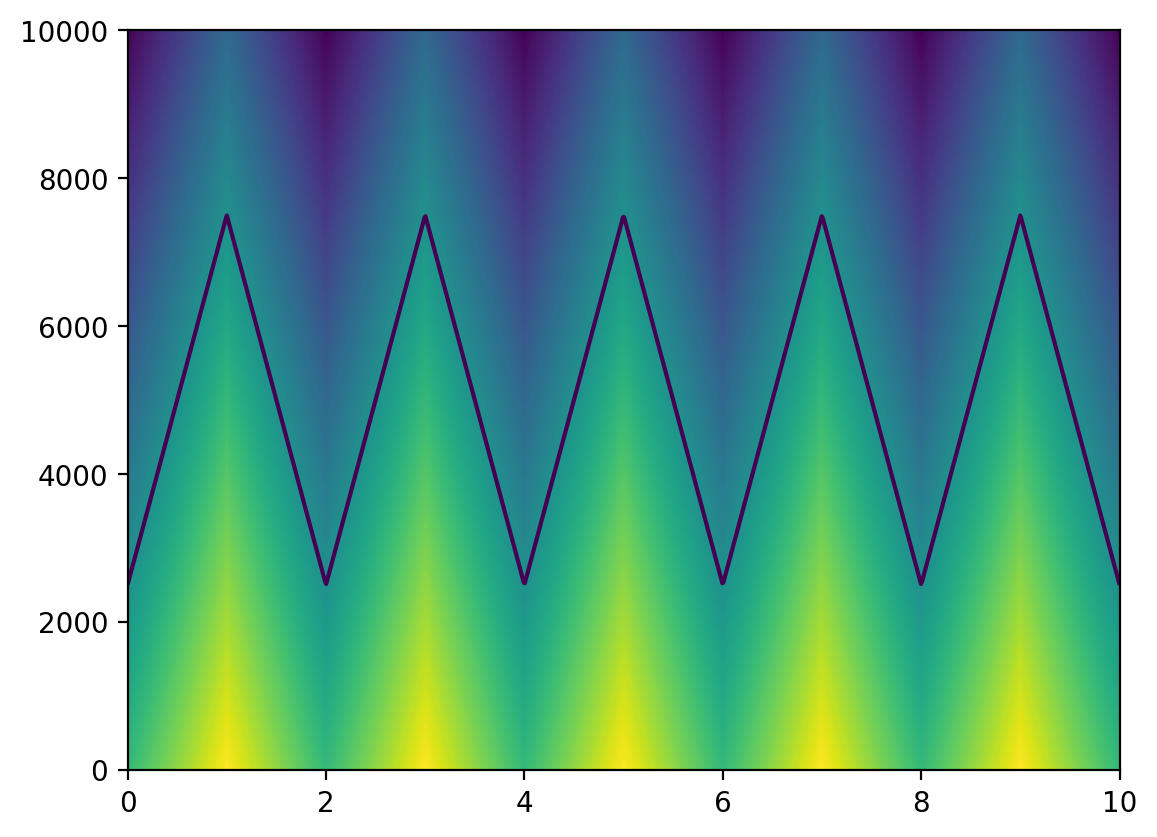

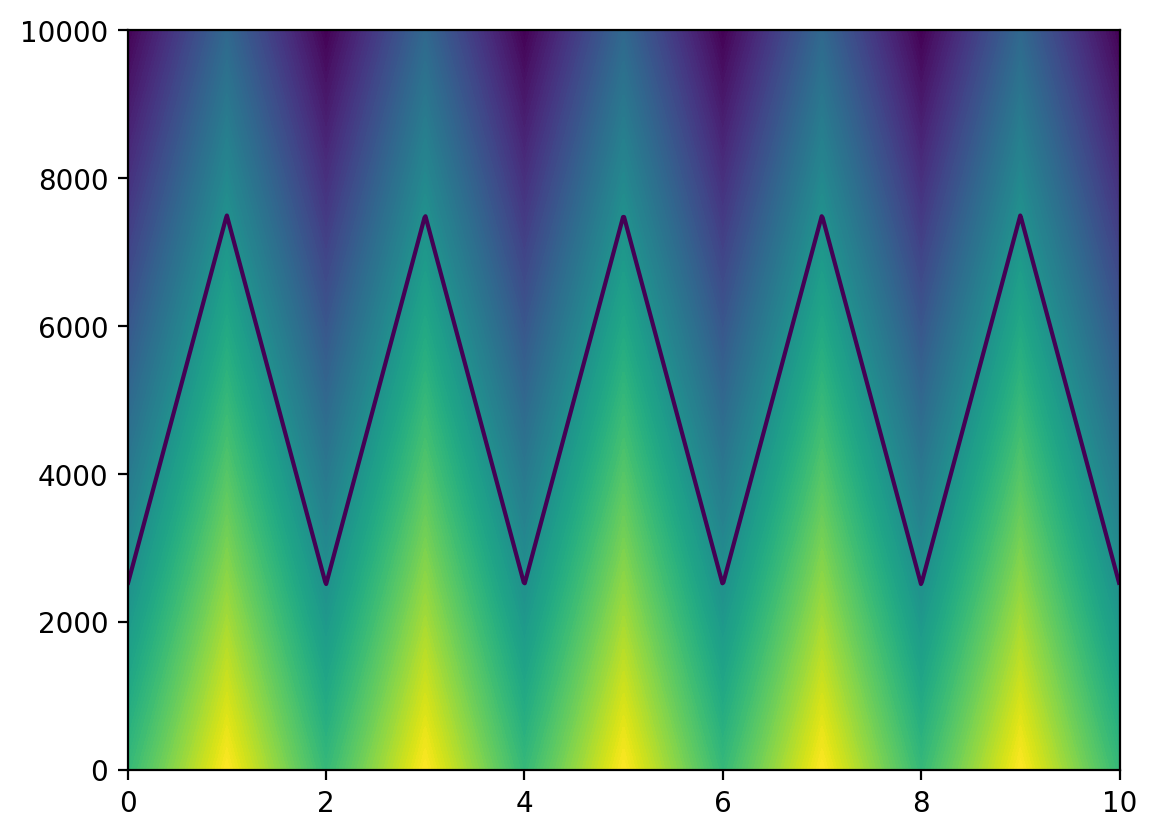

In [44]:
t_test = np.linspace(0, 10 * 24 * 60 * 60, 1000) 
x_test = np.linspace(0, 1e4, 1000)

tt_test, xx_test = np.meshgrid(t_test, x_test)
plt.contourf(t_test/86400, x_test, u_moving_sharply2(tt_test, xx_test, U0=0.25, U0_amp=0.125, U0_period=24 * 60 * 60, dudx=-5e-5, sign=1), levels=100)
plt.contour(t_test/86400, x_test, u_moving_sharply2(tt_test, xx_test, U0=0.25, U0_amp=0.125, U0_period=24 * 60 * 60, dudx=-5e-5, sign=1), levels=[0])
plt.show()

plt.contourf(t_test/86400, x_test, u_moving_sharply2(tt_test, xx_test, U0=0.1, U0_amp=0.05, U0_period=24 * 60 * 60, dudx=-2e-5, sign=1), levels=100)
plt.contour(t_test/86400, x_test, u_moving_sharply2(tt_test, xx_test, U0=0.1, U0_amp=0.05, U0_period=24 * 60 * 60, dudx=-2e-5, sign=1), levels=[0])

100%|██████████| 14400/14400 [00:00<00:00, 25637.73it/s]


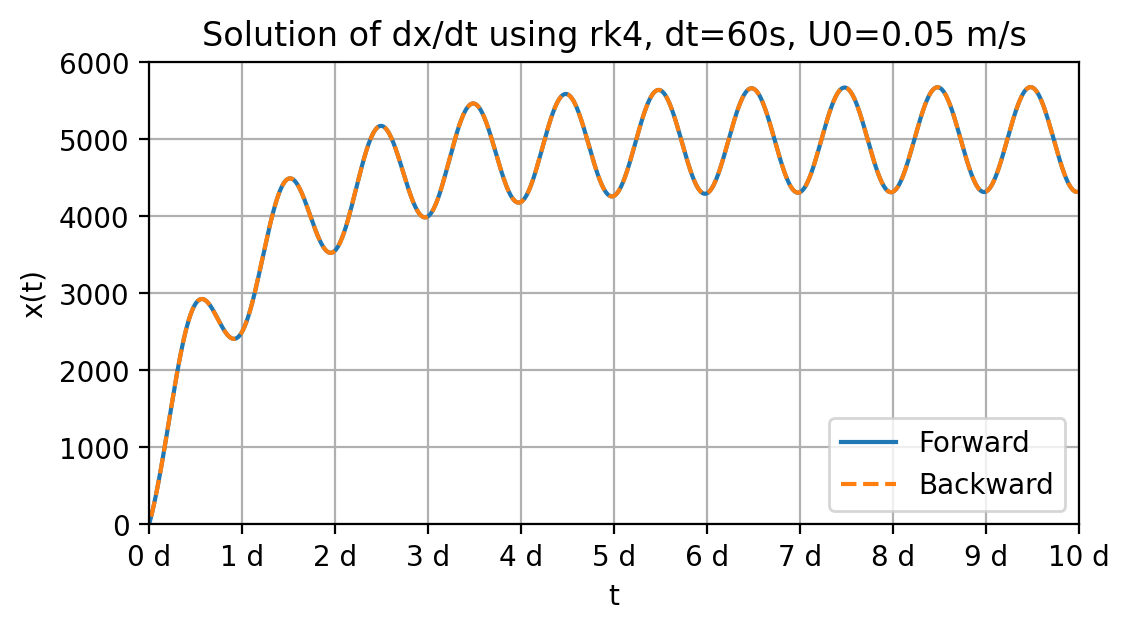

In [45]:
sensitivity_plot('rk4', 60, t0=0, t_end=10*24*60*60, U0=0.05, u_func=u_moving, return_results=False)


100%|██████████| 1440/1440 [00:00<00:00, 24672.98it/s]


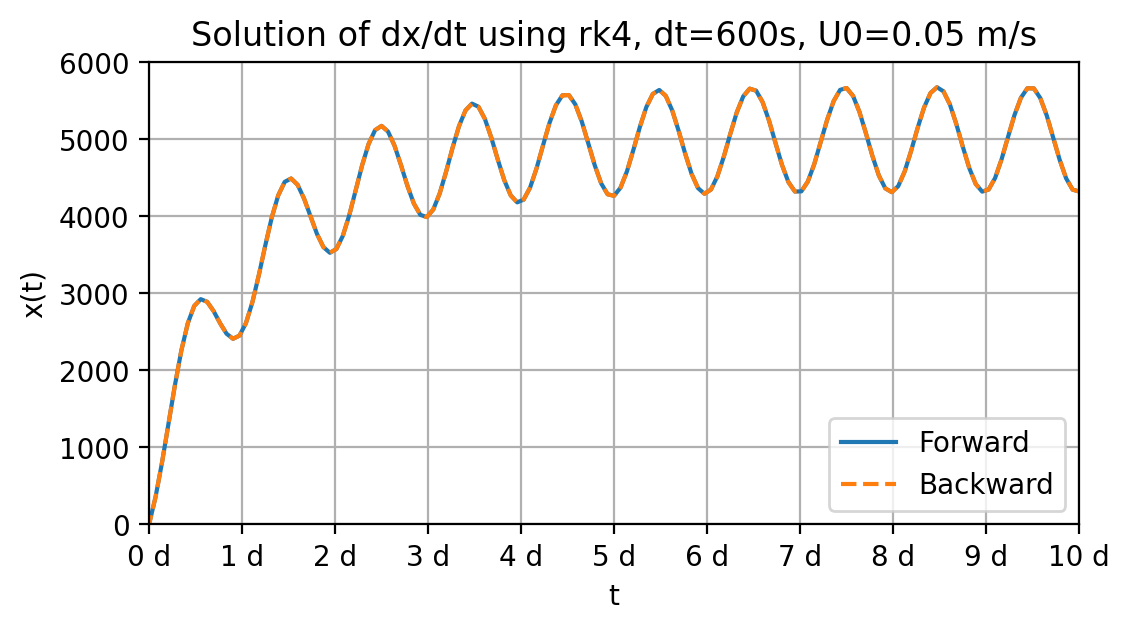

In [46]:
sensitivity_plot('rk4', 600, U0=0.05, u_func=u_moving, return_results=False)


100%|██████████| 240/240 [00:00<00:00, 22280.01it/s]


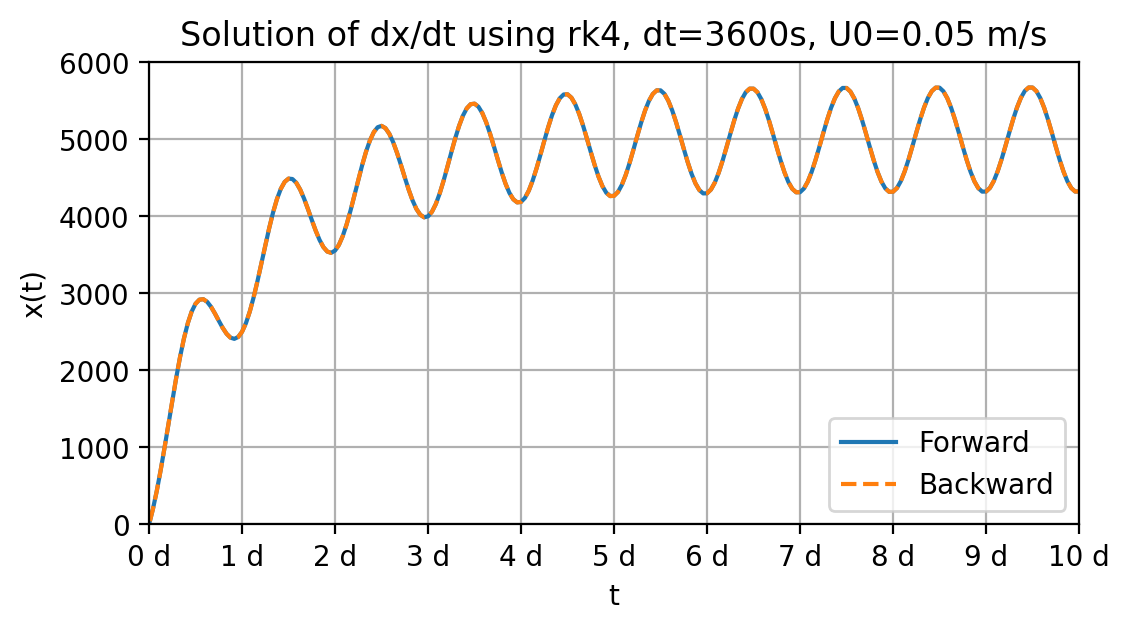

In [47]:
sensitivity_plot('rk4', 60*60, U0=0.05, u_func=u_moving, return_results=False, save_step=1)


100%|██████████| 14400/14400 [00:00<00:00, 24324.62it/s]


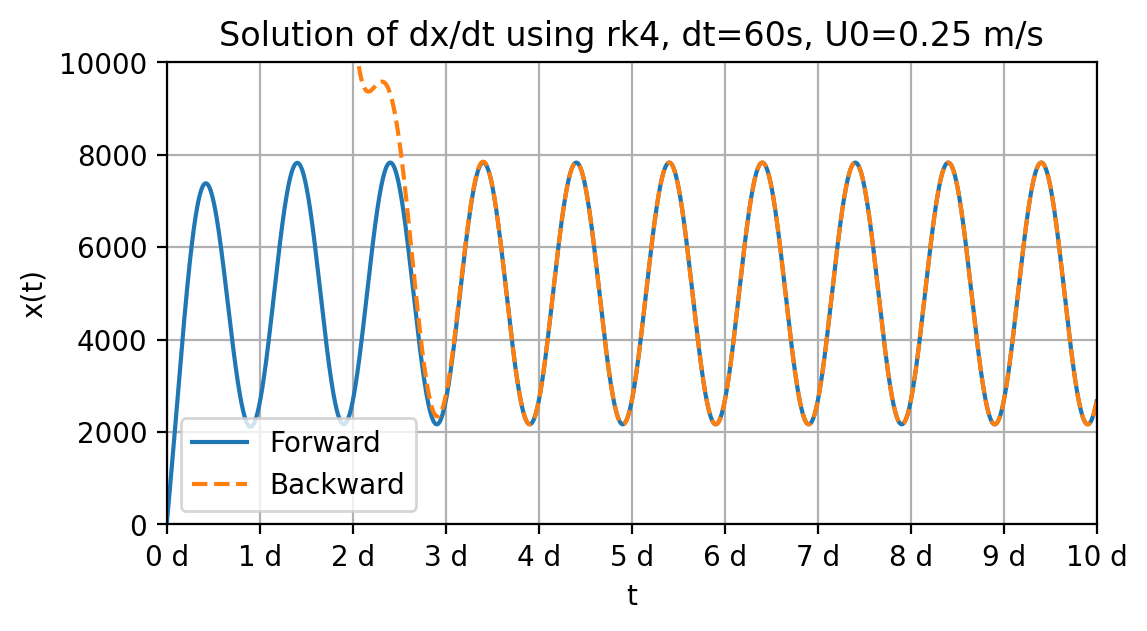

In [48]:
sensitivity_plot('rk4', 60, U0=0.25, U0_amp=0.25, dudx=-5e-5, u_func=u_moving, return_results=False, save_step=1, ylim='full')


100%|██████████| 1440/1440 [00:00<00:00, 23235.26it/s]


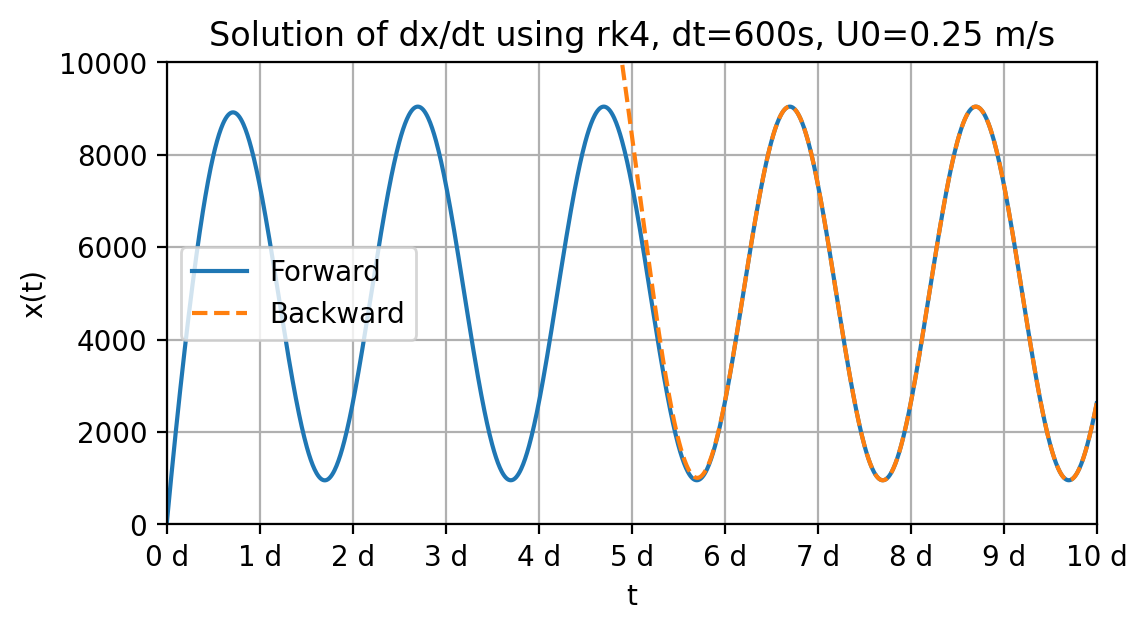

In [49]:
sensitivity_plot('rk4', 60*10, U0=0.25, U0_amp=0.25, dudx=-5e-5, t_end=10*24*60*60, U0_period=2*24*60*60, u_func=u_moving, return_results=False, save_step=1, ylim='full')


100%|██████████| 240/240 [00:00<00:00, 19915.58it/s]


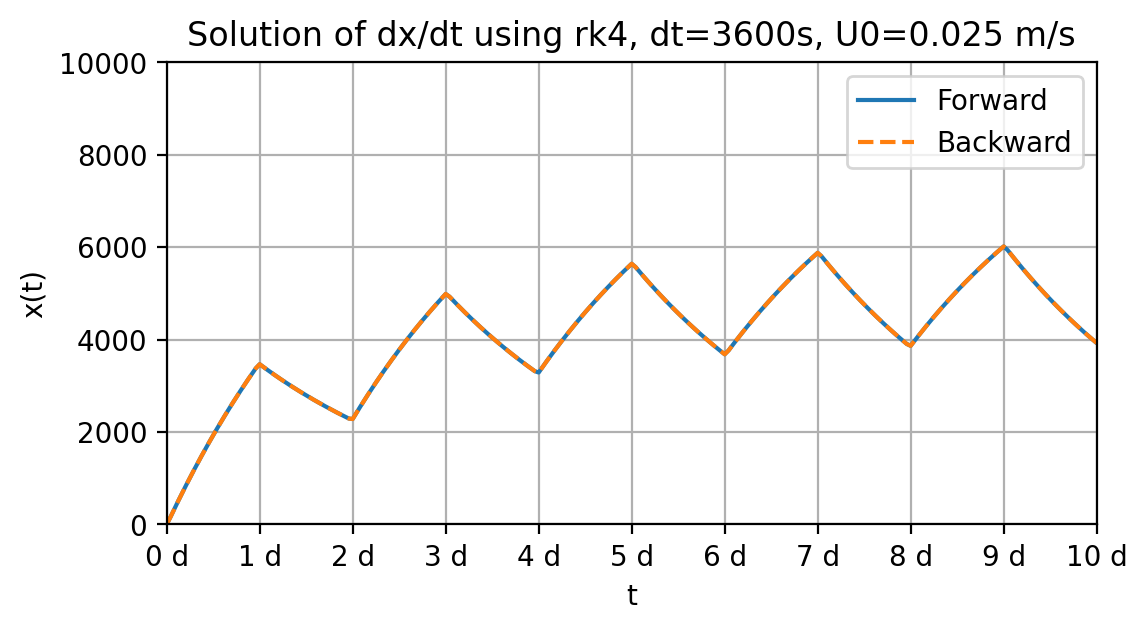

In [50]:
sensitivity_plot('rk4', 60*60, U0=0.025, U0_amp=0.025, dudx=-5e-6, t_end=10*24*60*60, U0_period=2*24*60*60, u_func=u_moving_sharply, return_results=False, save_step=1, ylim='full')


/tmp/ipykernel_140624/3970606820.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} km' for x in ax.get_xticks() / 1e3])
/tmp/ipykernel_140624/3970606820.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f'{round(y,2)} m' for y in ax.get_yticks()])


(<Figure size 600x300 with 2 Axes>, <Axes: >)

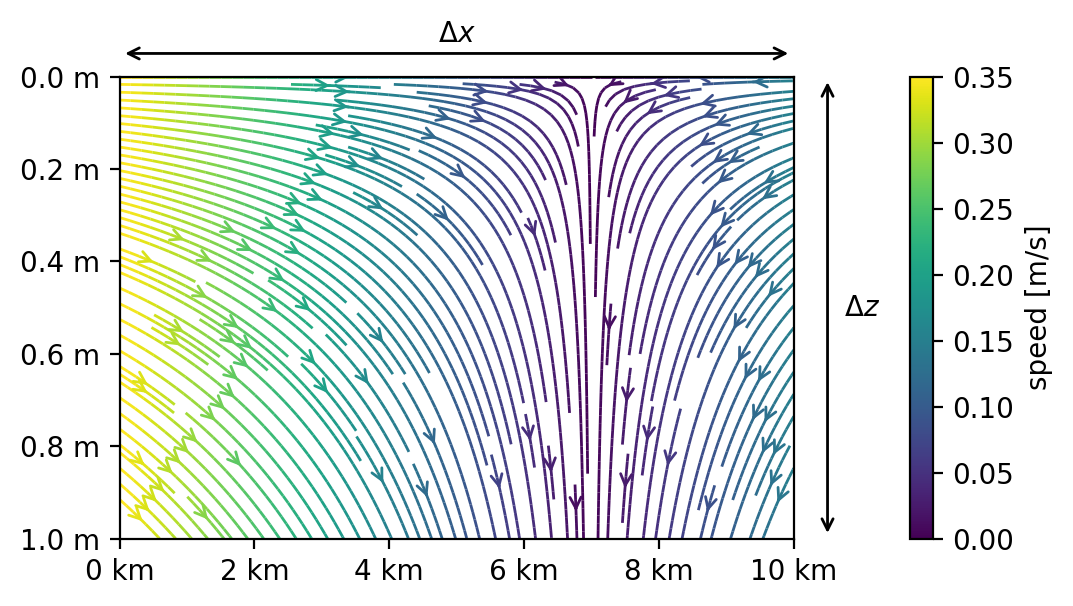

In [52]:
plot_streamlines(U0=0.35, U1 = - 0.15)

100%|██████████| 14400/14400 [00:00<00:00, 24191.07it/s]


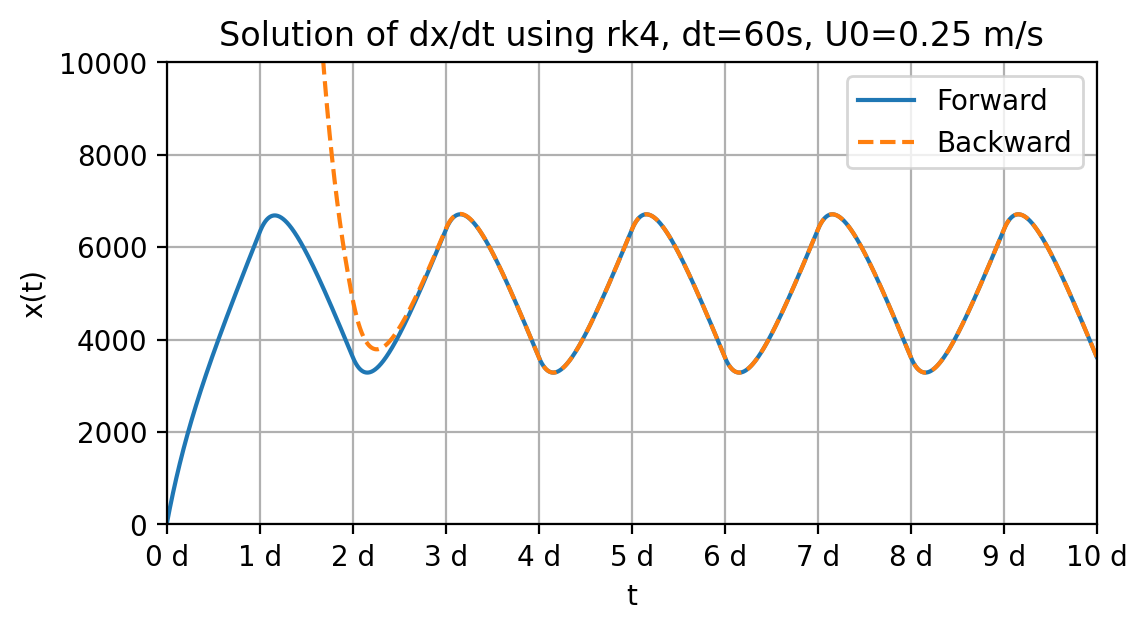

In [53]:
moving_attr_fw, moving_attr_bw = sensitivity_plot('rk4', 60, U0=0.25, U0_amp=0.125, dudx=-5e-5, t_end=10*24*60*60, U0_period=24*60*60, u_func=u_moving_sharply2, return_results=True, save_step=1, ylim='full')


100%|██████████| 1440/1440 [00:00<00:00, 22702.59it/s]


100%|██████████| 1440/1440 [00:00<00:00, 22816.06it/s]


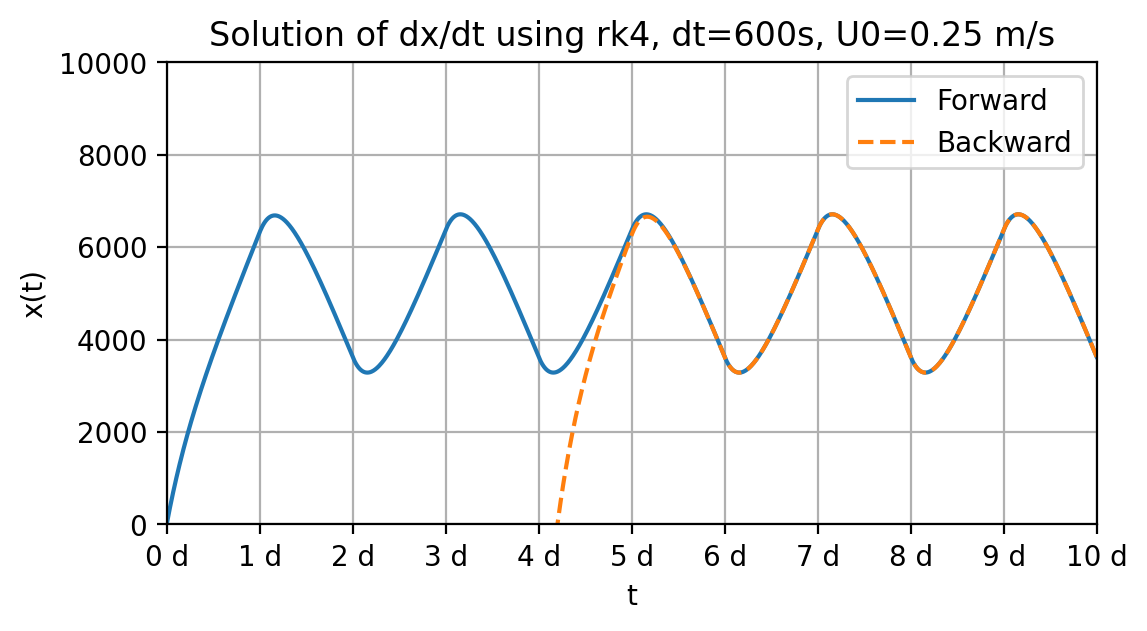

In [54]:
moving_attr_fw, moving_attr_bw = sensitivity_plot('rk4', 60*10, U0=0.25, U0_amp=0.125, dudx=-5e-5, t_end=10*24*60*60, U0_period=24*60*60, u_func=u_moving_sharply2, return_results=True, save_step=1, ylim='full')


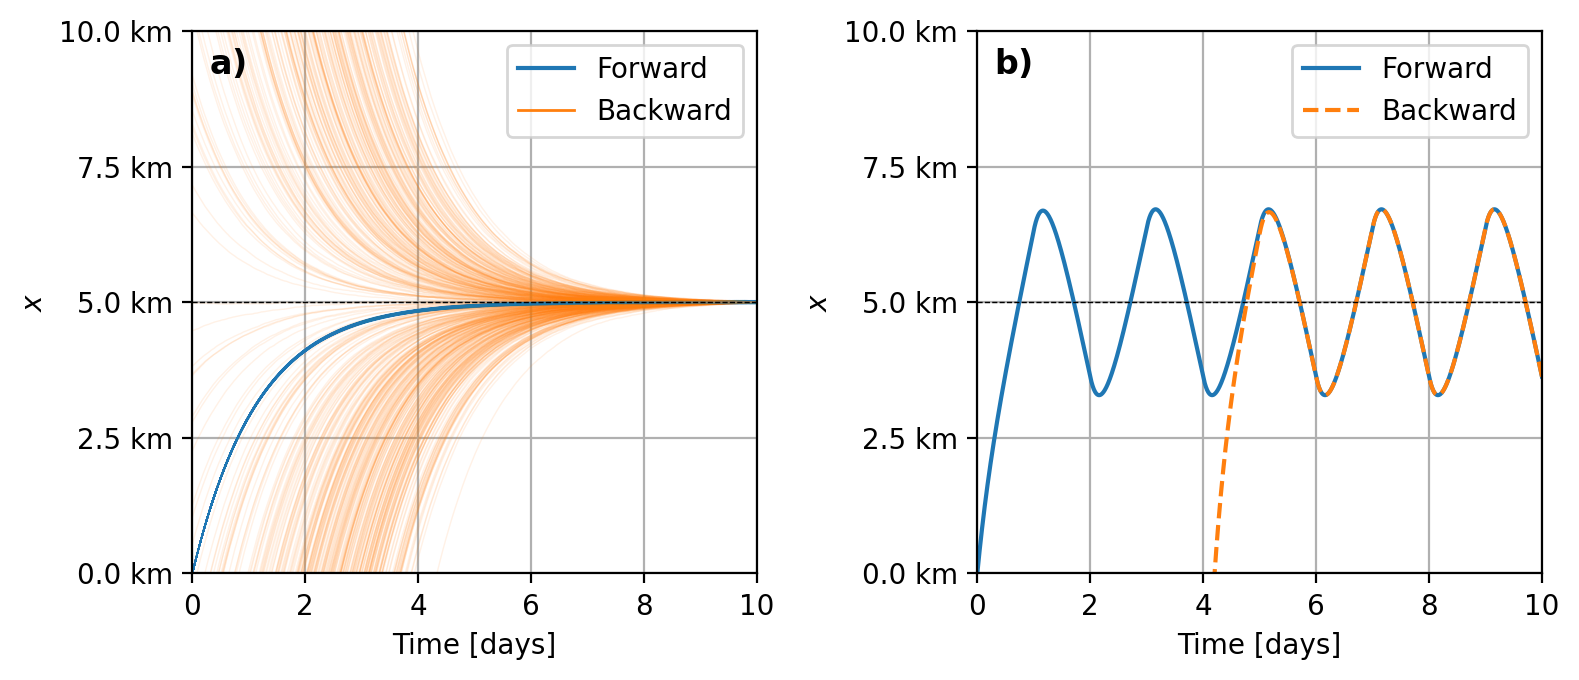

In [56]:
plt.style.context('default')
fig, ax = plt.subplots(ncols=2, figsize=(8, 3.5))
scale_t = 86400

for i in range(500):
    ax[0].plot(dict_rk4_kh_sensitivity[1e-6]["forward"].t / scale_t, dict_rk4_kh_sensitivity[1e-6]["forward"].x[:, i], alpha=0.1, linewidth=0.5, color='C0')
    ax[0].plot(dict_rk4_kh_sensitivity[1e-6]["backward"].t / scale_t, dict_rk4_kh_sensitivity[1e-6]["backward"].x[:, i], alpha=0.1, linewidth=0.5, color='C1')
    labels = ["Forward", "Backward"]  
    dummies = [ax[0].plot([], [], f'C0')[0], ax[0].plot([], [], f'C1', linewidth=1)[0]]
    ax[0].legend(dummies, labels, loc='upper right')

ax[1].plot(moving_attr_fw.t / scale_t, moving_attr_fw.x, label='Forward')
ax[1].plot(moving_attr_bw.t / scale_t, moving_attr_bw.x, label='Backward', linestyle='--')
ax[1].legend()

yticks = range(0, 10001, 2500)


for axidx in [0, 1]:
    ax[axidx].axhline(5000, color='k', linestyle='--', linewidth=0.5)
    ax[axidx].set_xlabel('Time [days]')
    ax[axidx].set_ylim(0, 1e4)
    ax[axidx].set_xlim(0, 10)
    ax[axidx].grid(True)
    ax[axidx].set_yticks(yticks)
    ax[axidx].set_ylabel('$x$')
    ax[axidx].set_yticklabels([f'{round(tick, 1)} km' for tick in ax[axidx].get_yticks() / 1000])

# ax[0].set_title(r"$\bf{a)}$ ")

ax[0].text(0.03, 0.97, r"$\bf{a)}$", transform=ax[0].transAxes, fontsize=12, va='top')
ax[1].text(0.03, 0.97, r"$\bf{b)}$", transform=ax[1].transAxes, fontsize=12, va='top')


fig.tight_layout()
plt.savefig("idealized_numerical_errors.pdf", bbox_inches='tight')
plt.show()

100%|██████████| 432/432 [00:00<00:00, 17803.73it/s]


/tmp/ipykernel_5607/10801437.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


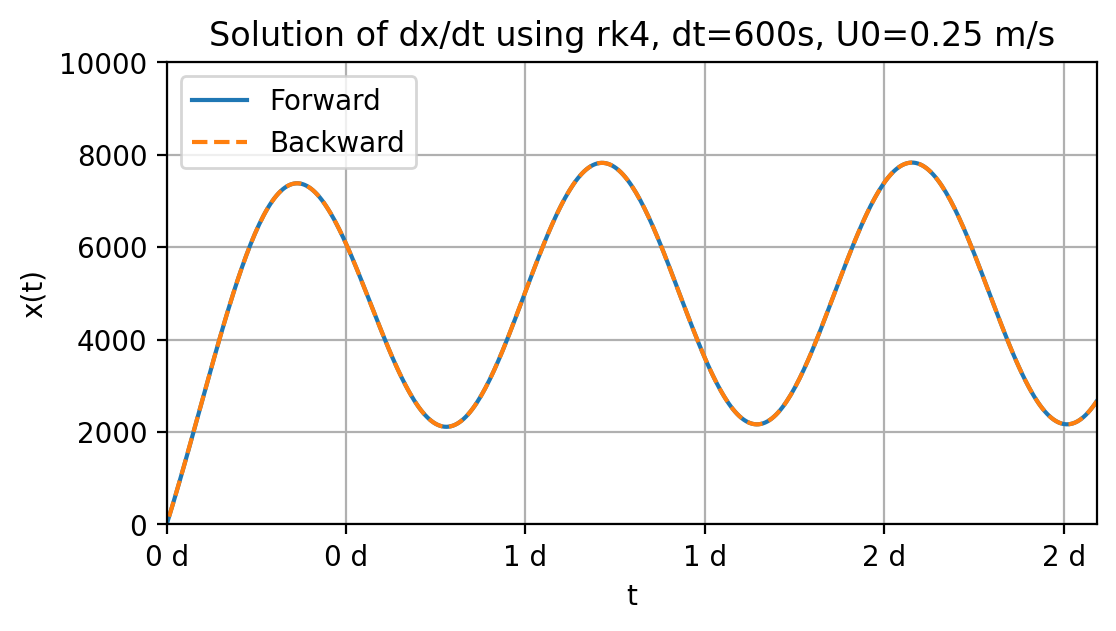

In [37]:
sensitivity_plot('rk4', 600, U0=0.25, U0_amp=0.25, dudx=-5e-5, 
                 u_func=u_moving, return_results=False, save_step=1,
                 t0=0, t_end=3*24*60*60, ylim='full')


100%|██████████| 14400/14400 [00:00<00:00, 19668.87it/s]
/tmp/ipykernel_5607/10801437.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


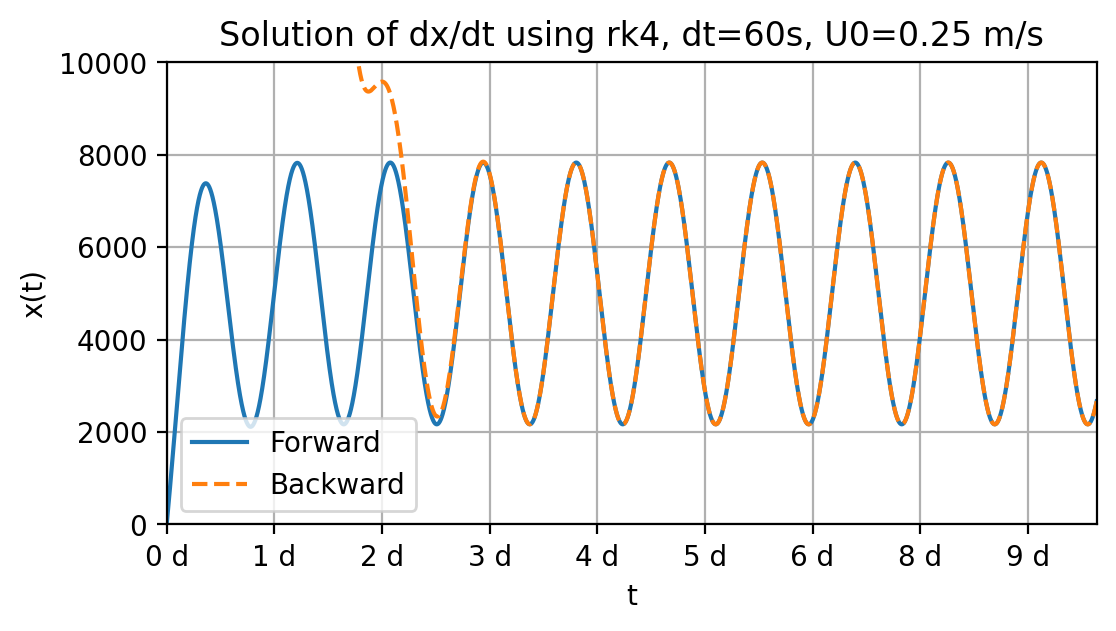

In [38]:
sensitivity_plot('rk4', 60, U0=0.25, U0_amp=0.25, dudx=-5e-5, u_func=u_moving, return_results=False, save_step=1, ylim='full')


100%|██████████| 240/240 [00:00<00:00, 39780.00it/s]
/tmp/ipykernel_5607/10801437.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


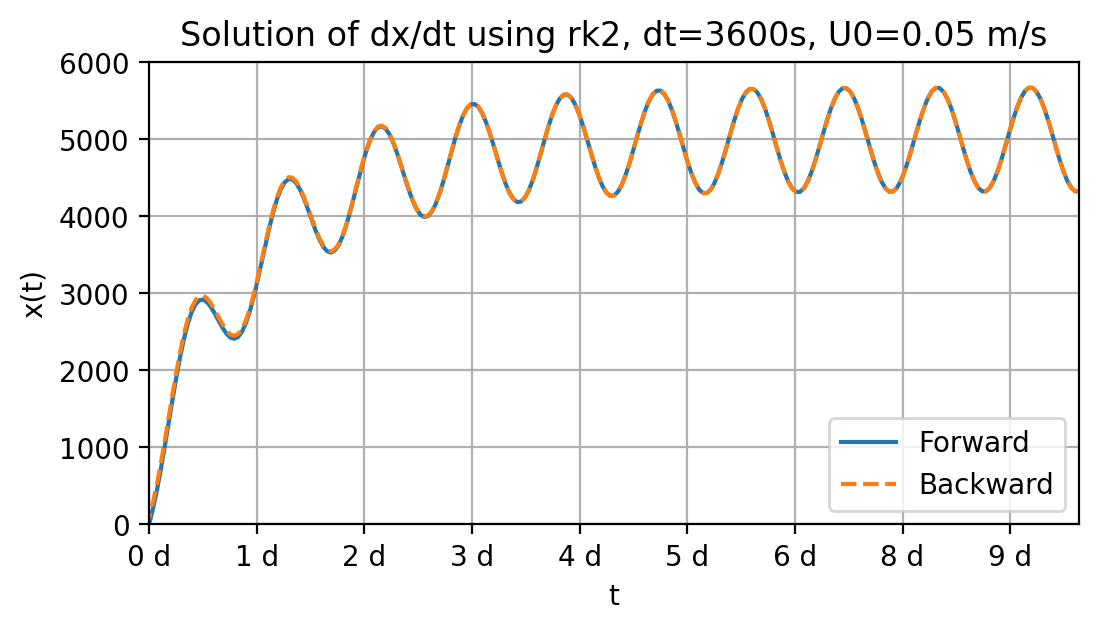

In [39]:
sensitivity_plot('rk2', 3600, U0=0.05, u_func=u_moving, save_step=1, return_results=False)


100%|██████████| 1440/1440 [00:00<00:00, 82708.63it/s]
/tmp/ipykernel_5607/10801437.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


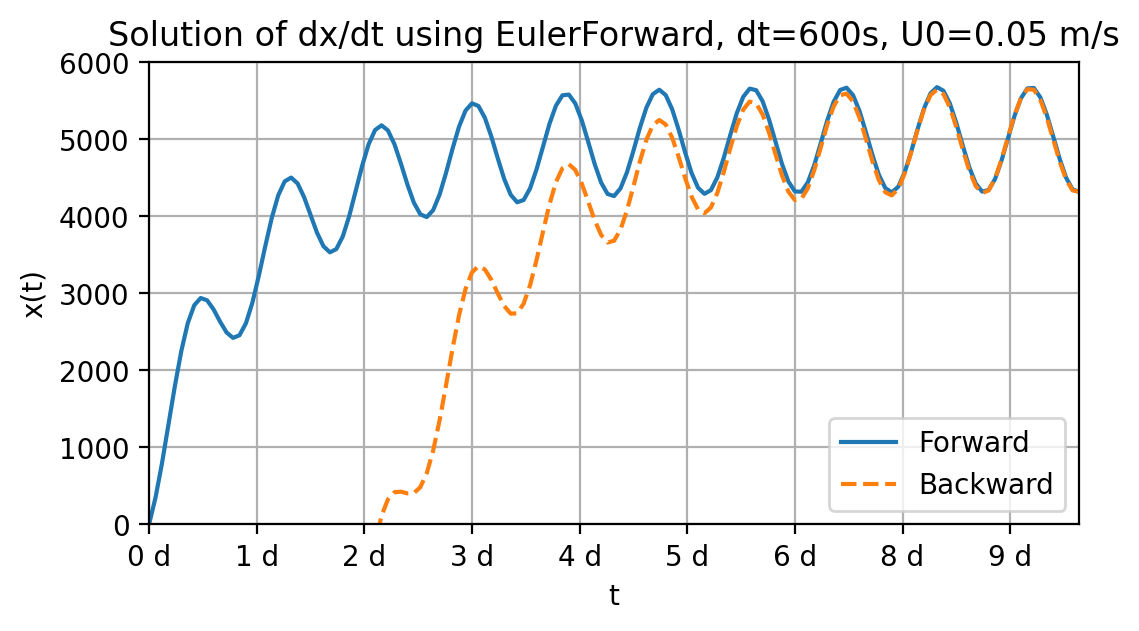

In [40]:
sensitivity_plot('EulerForward', 600, U0=0.05, u_func=u_moving, return_results=False)


# Submesoscale

100%|██████████| 1440/1440 [00:00<00:00, 24823.26it/s]
/tmp/ipykernel_5607/3648038082.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


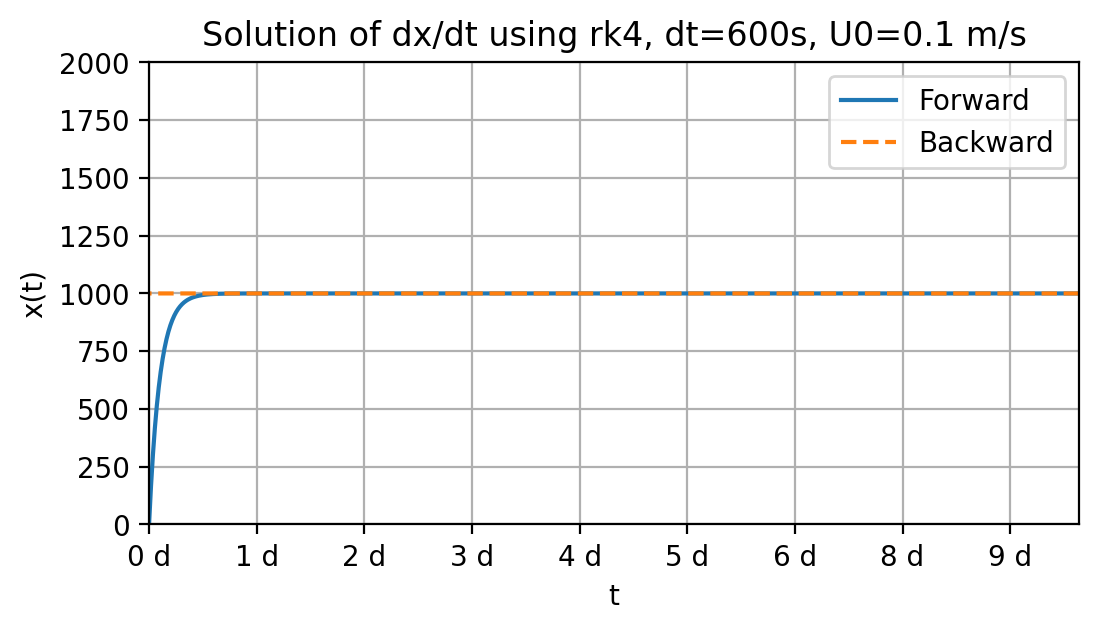

In [52]:
sensitivity_plot('rk4', 600, U0=0.1, dx=2000, u_func=u, save_step=1, return_results=False, ylim=(0, 2000))

 31%|███       | 4418/14400 [00:00<00:00, 22122.68it/s]

100%|██████████| 14400/14400 [00:00<00:00, 22652.14it/s]
/tmp/ipykernel_5607/3648038082.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


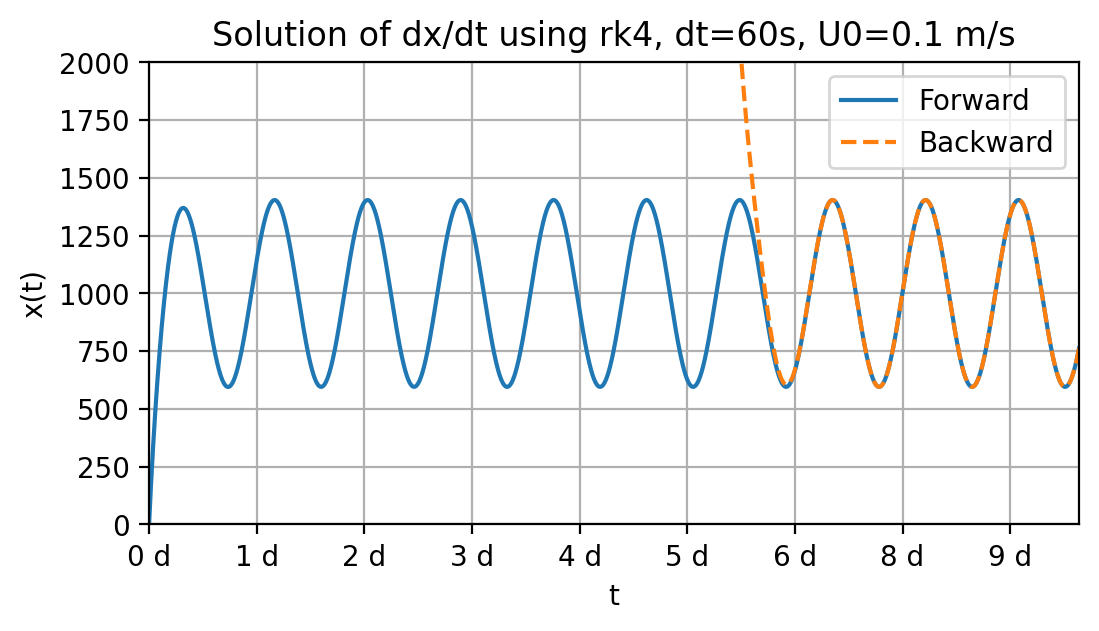

In [55]:
sensitivity_plot('rk4', 60, U0=0.1, dx=2000, u_func=u_moving, save_step=1, dudx=-1e-4, return_results=False, ylim=(0, 2000))

  0%|          | 0/14400 [00:00<?, ?it/s]

100%|██████████| 14400/14400 [00:00<00:00, 23010.42it/s]
/tmp/ipykernel_5607/3648038082.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f'{int(x)} d' for x in ax.get_xticks() / (24*60*60)])


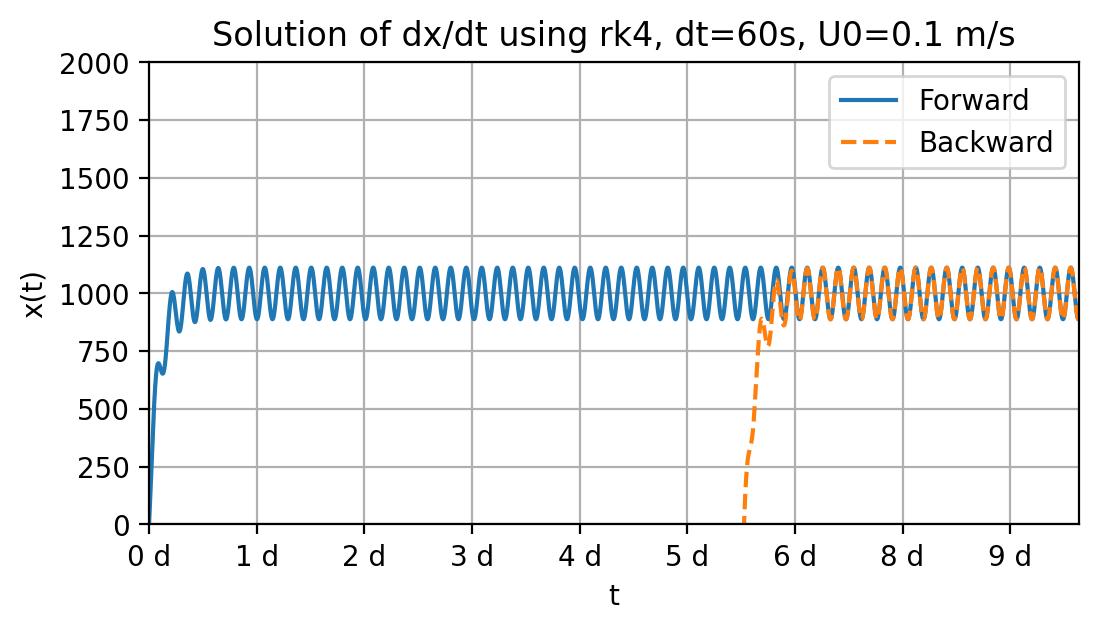

In [58]:

sensitivity_plot('rk4', 60, U0=0.1, dx=2000, u_func=u_moving, U0_period=4*60*60, save_step=1, dudx=-1e-4, return_results=False, ylim=(0, 2000))